# Failure Prediction for Network Equipment

Классификация выхода из строя за сутки до инцидента  
Типы оборудования — Eltex1/Eltex2.*

## Imports и глобальная конфигурация

In [70]:
import os
import re
import glob
import gzip
import json
from pathlib import Path
from tqdm import tqdm
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import iqr

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, classification_report
)
from sklearn.model_selection import GroupKFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import optuna
import lightgbm as lgb
import xgboost as xgb

import joblib
import torch

pd.set_option("display.max_columns", 150)
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------
# Константы и пути
# --------------------------------------------------
BASE_DIR         = Path().resolve()
METRICS_GLOB     = str(BASE_DIR / "metrics" / "vtb_export_*" / "*.txt.gz")
INCIDENTS_PATH   = BASE_DIR / "incidents" / "incidents_union.csv"
INFO_PATH        = BASE_DIR / "info" / "info_union.csv"

MODEL_DIR        = BASE_DIR / "models"
OUTPUT_DIR       = BASE_DIR / "processed_data"

MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ML / FE constants
TIME_LAG        = pd.Timedelta("24H")
RESAMPLE_FREQ   = "30T"
RANDOM_STATE    = 42
N_TRIALS        = 40
CV_SPLITS       = 3
EARLY_STOP_PATIENCE = 10
DEVICE_COL, TIME_COL, TARGET_COL = "ip_address", "timestamp", "target"

IS_GPU = torch.cuda.is_available()
IS_GPU = False

In [3]:
IS_GPU

False

In [71]:
import re

def make_unique_columns(columns):
    seen = {}
    result = []
    for col in columns:
        # Заменяем спецсимволы на "_"
        clean_col = re.sub(r'[^a-zA-Zа-яА-Я0-9_]', '_', col)
        clean_col = re.sub(r'_+', '_', clean_col).strip('_')
        
        # Если название уже было, добавляем счетчик
        if clean_col in seen:
            seen[clean_col] += 1
            clean_col = f"{clean_col}_{seen[clean_col]}"
        else:
            seen[clean_col] = 1
        
        result.append(clean_col)
    
    return result

def load_incidents(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["incident_time"] = pd.to_datetime(df["incident_time"], errors="coerce")
    df = df.dropna(subset=["incident_time"])
    return df


def load_info(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path).drop_duplicates(subset=["item_id"])
    df = df.rename(columns={"name": "metric_name", "ipaddress": "ip_address"})
    return df[["item_id", "metric_name", "ip_address"]]


def build_ip_incident_map(df: pd.DataFrame) -> Dict[str, List[pd.Timestamp]]:
    m: Dict[str, List[pd.Timestamp]] = {}
    for ip, sub in df.groupby(DEVICE_COL):
        times = sorted(sub['incident_time'].tolist())
        m[ip] = times
    return m


def label_target(df: pd.DataFrame, ip_map: Dict[str, List[pd.Timestamp]]) -> pd.DataFrame:
    df[TARGET_COL] = 0
    for ip, times in ip_map.items():
        if ip not in df[DEVICE_COL].unique():
            continue
        for t in times:
            start = t - TIME_LAG
            mask = (df[DEVICE_COL] == ip) & \
                   (df['timestamp'] >= start) & \
                   (df['timestamp'] <= t)
            df.loc[mask, TARGET_COL] = 1
    return df


def process_file(
    file_path: str,
    map_item_to_name: Dict[str, str],
    map_item_to_ip: Dict[str, str],
    ip_inc_map: Dict[str, List[pd.Timestamp]],
    resample_freq: str = RESAMPLE_FREQ,
    label: bool = True,
) -> pd.DataFrame:
    # ---------- 1. load ----------------------------------------------------
    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        tmp = pd.read_csv(f)
    tmp = tmp[tmp["itemId"] != "itemId"]
    tmp.columns = ["item_id", "unix_ts", "value"]

    # ---------- 2. timestamp ----------------------------------------------
    tmp["timestamp"] = pd.to_datetime(tmp["unix_ts"], unit="s", errors="coerce")
    tmp = tmp.dropna(subset=["timestamp", "value"])
    if tmp.empty:                       # 🆕 ничего живого в файле
        return pd.DataFrame()

    tmp["timestamp"] = tmp["timestamp"].dt.floor(resample_freq)

    # ---------- 3. map -----------------------------------------------------
    tmp["metric_name"] = tmp["item_id"].map(map_item_to_name)
    tmp["ip_address"]  = tmp["item_id"].map(map_item_to_ip)
    tmp["value"]       = pd.to_numeric(tmp["value"], errors="coerce")
    tmp = tmp.dropna(subset=["metric_name", "ip_address"])
    if tmp.empty:                       # 🆕 после map всё исчезло
        return pd.DataFrame()

    # ---------- 4. pivot ---------------------------------------------------
    df_pivot = (
        tmp.groupby(["timestamp", "ip_address", "metric_name"])["value"]
           .mean()
           .unstack(fill_value=np.nan)
           .reset_index()
    )
    if df_pivot.empty:
        return pd.DataFrame()

    # ---------- 5. ffill per device ---------------------------------------
    frames  = []
    for ip in df_pivot["ip_address"].unique():
        df_ip = df_pivot[df_pivot["ip_address"] == ip].copy()
        df_ip = df_ip.sort_values("timestamp").set_index("timestamp").ffill()

        full_idx = pd.date_range(df_ip.index.min(), df_ip.index.max(), freq=resample_freq)
        df_ip    = df_ip.reindex(full_idx).ffill()

        df_ip["ip_address"] = ip
        df_ip["timestamp"]  = df_ip.index
        frames.append(df_ip.reset_index(drop=True))

    # ---------- защита от пустоты после цикла -----------------------------
    if not frames:                      # 🆕 ничего не набралось
        return pd.DataFrame()

    result = pd.concat(frames, ignore_index=True)

    # ---------- 6. label ---------------------------------------------------
    if label and ip_inc_map:
        result = label_target(result, ip_inc_map)
    else:
        result[TARGET_COL] = np.nan

    return result


def save_processed_part(
    part_df: pd.DataFrame,
    src_path: str,
    out_dir: Path,
    fmt: str = "parquet"
):
    """
    Сохраняет обработанный df так, чтобы одинаковые <device>.txt.gz
    из разных месяцев НЕ перезаписывали друг друга.
    
    part_df  : результат process_file(...)
    src_path : оригинальный путь к .txt.gz
    out_dir  : базовая папка для сохранения
    """
    month_tag = Path(src_path).parent.name
    device_tag = Path(src_path).stem
    fname = f"{month_tag}__{device_tag}.{fmt}"
    out_path = out_dir / fname
    out_path.parent.mkdir(parents=True, exist_ok=True)
    
    if fmt == "csv":
        part_df.to_csv(out_path, index=False)
    else:
        part_df.to_parquet(out_path, index=False)
    return out_path


# ============================= 2. process_all =============================
def process_all(
    metrics_glob: str = METRICS_GLOB,
    incidents_path: Optional[Path] = INCIDENTS_PATH,
    info_path: Path = INFO_PATH,
    out_dir: Path = OUTPUT_DIR,
    save_format: str = "csv",
    is_test: bool = False                   # <-- новое: метка режима
) -> pd.DataFrame:

    # --- incidents ---------------------------------------------------------
    if not is_test and incidents_path and incidents_path.exists():
        inc_df  = load_incidents(incidents_path)
        ip_map  = build_ip_incident_map(inc_df)
    else:                                   # test-режим: пустая карта инцидентов
        ip_map  = {}

    # --- info --------------------------------------------------------------
    info_df = load_info(info_path)
    map_item_to_name = dict(zip(info_df["item_id"], info_df["metric_name"]))
    map_item_to_ip   = dict(zip(info_df["item_id"], info_df["ip_address"]))

    # --- обход файлов ------------------------------------------------------
    files = glob.glob(metrics_glob)
    all_parts = []
    for fp in tqdm(files):
        df_dev = process_file(
            fp,
            map_item_to_name,
            map_item_to_ip,
            ip_map,
            label=not is_test           # train -> размечаем, test -> нет
        )
        if df_dev.empty:                # пропускаем пустышки
            continue
        save_processed_part(df_dev, src_path=fp, out_dir=out_dir, fmt=save_format)
        all_parts.append(df_dev)

    if not all_parts:                   # защита от полного отсутствия данных
        raise ValueError("process_all: ни один файл не дал данных – проверьте пути")

    combined = pd.concat(all_parts, ignore_index=True)
    return combined


def reduce_memory_usage(
    df: pd.DataFrame,
    categorical_threshold: float = 0.50,
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Cнижение потребления памяти без потери точности.
    """
    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    df_opt = df.copy()

    # Удаляем технический индекс
    if "Unnamed: 0" in df_opt.columns:
        df_opt = df_opt.drop(columns="Unnamed: 0")

    for col in df_opt.columns:
        col_type = df_opt[col].dtype

        if col_type == object:
            if col == "timestamp":
                df_opt[col] = pd.to_datetime(df_opt[col], errors="coerce")
            elif col == "ip_address":
                df_opt[col] = df_opt[col].astype("category")
            else:
                nunique = df_opt[col].nunique(dropna=False)
                if nunique / len(df_opt) < categorical_threshold:
                    df_opt[col] = df_opt[col].astype("category")

        elif pd.api.types.is_integer_dtype(col_type):
            df_opt[col] = pd.to_numeric(df_opt[col], downcast="unsigned")

        elif pd.api.types.is_float_dtype(col_type):
            # Без округления: просто переводим в float32
            df_opt[col] = df_opt[col].astype(np.float32)

        elif pd.api.types.is_bool_dtype(col_type) or col == "target":
            df_opt[col] = df_opt[col].astype("uint8")

    end_mem = df_opt.memory_usage(index=True, deep=True).sum() / 1024**2
    if verbose:
        print(f"Memory: {start_mem:0.2f} → {end_mem:0.2f} MiB "
              f"({100 * (start_mem - end_mem) / start_mem:0.1f}% экономии)")
    return df_opt


def add_window_features(
    df: pd.DataFrame,
    windows: List[int] = [6, 12]
) -> pd.DataFrame:
    """
    Compute rolling mean/std per device and metric for given window sizes.
    Memory optimized version.
    """
    num_cols = [c for c in df.columns if c not in ['ip_address', 'timestamp', 'target', 'TYPE']]
    df = df.sort_values(['ip_address', 'timestamp'])

    new_features = []

    grouped = df.groupby('ip_address')
    for w in windows:
        roll = grouped[num_cols].rolling(w, min_periods=1)
        stats = roll.agg(['mean', 'std'])
        stats.columns = [f"{col}_r{w}_{stat}" for col, stat in stats.columns]
        stats = stats.reset_index(level=0, drop=True)
        new_features.append(stats)

    # Аккуратно объединяем все новые признаки в один датафрейм
    new_features_df = pd.concat(new_features, axis=1)

    # Конкатенируем оригинальные данные с новыми признаками
    out = pd.concat([df.reset_index(drop=True), new_features_df], axis=1)
    return out


def prepare_dataset(
    df: pd.DataFrame,
    feature_list_path: Optional[Path] = None,
    rename_map_path:  Optional[Path] = None,
    is_test: bool = False,
) -> pd.DataFrame:
    """
    Единая функция для train- и test-пайплайна.

    Train-режим (is_test=False):
      • вычисляет список «сырых» признаков (= до make_unique_columns)
      • генерирует rename_map : raw_name ➜ clean_name
      • сохраняет feature_list.json   – порядок «raw»
      • сохраняет rename_map.json     – словарь переименования
      • возвращает df с очищенными именами + rolling-фичи

    Test-режим  (is_test=True):
      • читает rename_map.json, применяет к датафрейму
      • добавляет NaN-колонки для недостающих «raw» имён
      • выбрасывает лишние колонки, чтобы порядок совпал c train
      • возвращает df с теми же clean-именами + rolling-фичи
    """
    # ------------------------------------------------------------------
    # 1. определить набор raw-признаков
    # ------------------------------------------------------------------
    # df = reduce_memory_usage(df)
    if is_test:
        # ---------- test: загружаем справочные файлы -------------------
        if rename_map_path is None or not Path(rename_map_path).exists():
            raise FileNotFoundError("rename_map_path для test-режима не найден")

        with open(rename_map_path, "r", encoding="utf-8") as f:
            rename_map: Dict[str, str] = json.load(f)

        raw_features = list(rename_map.keys())        # порядок как в train

        # ------------------------------------------------------------------
        # 1.1  гарантируем наличие всех raw-колонок
        # ------------------------------------------------------------------
        for col in raw_features:
            if col not in df.columns:
                df[col] = np.nan

        # выбрасываем «лишние» метрики, которых модель не знает
        df = df[["ip_address", "timestamp", "target"] + raw_features]

        # применяем ТОТ ЖЕ rename_map (без make_unique_columns!)
        df = df.rename(columns=rename_map)

    else:
        # ---------- train: формируем mapping ----------------------------
        raw_features = [
            c for c in df.columns
            if c not in ("ip_address", "timestamp", "target")
        ]
        clean_features = make_unique_columns(raw_features)
        rename_map = dict(zip(raw_features, clean_features))

        # сохраняем справочные файлы
        if feature_list_path:
            Path(feature_list_path).write_text(
                json.dumps(raw_features, indent=2, ensure_ascii=False), encoding="utf-8"
            )
        if rename_map_path:
            Path(rename_map_path).write_text(
                json.dumps(rename_map, indent=2, ensure_ascii=False), encoding="utf-8"
            )

        # применяем mapping
        df = df[["ip_address", "timestamp", "target"] + raw_features]\
               .rename(columns=rename_map)

    # ------------------------------------------------------------------
    # 2. rolling-признаки
    # ------------------------------------------------------------------
    df = add_window_features(df)
    # df = reduce_memory_usage(df)
    return df


In [5]:
def build_test_dataset(
    metrics_glob: str,
    feature_list_path: Path,
    rename_map_path:  Path,
    out_csv: Path,
    out_dir_tmp: Path = OUTPUT_DIR / "tmp_test",
) -> pd.DataFrame:
    """
    Готовит тестовый датасет «под ключ».

    1. process_all   – парсит сырые *.txt.gz, БЕЗ таргета (is_test=True)
    2. prepare_dataset – приводит набор признаков к train-формату
    3. сохраняет итоговый CSV      (out_csv)
    """
    # --- 1. raw ➜ metrics_df --------------------------------------------
    metrics_df = process_all(
        metrics_glob=metrics_glob,
        out_dir=out_dir_tmp,
        is_test=True
    )

    # --- 2. финальный датасет -------------------------------------------
    full_df = prepare_dataset(
        metrics_df,
        feature_list_path=feature_list_path,
        rename_map_path = rename_map_path,
        is_test=True
    )

    full_df.to_csv(out_csv, index=False)
    return full_df


In [ ]:
import numpy as np
import pandas as pd

# ---------- 1. calc_hours_to_fail (готовим один раз) -----------------
def calc_hours_to_fail(df, inc_df,
                       max_lag_hours=24,
                       time_col=TIME_COL,
                       device_col=DEVICE_COL,
                       incident_col="incident_time"):
    """
    Series: floor(Δt) в часах до ближайшей будущей аварии; NaN, если Δt > 24 h.
    """
    out = np.full(len(df), np.nan, dtype="float64")
    max_ns = max_lag_hours * 3_600_000_000_000

    ts_ns = df[time_col].astype("datetime64[ns]").view("int64").to_numpy()
    inc_map = (
        inc_df.groupby(device_col)[incident_col]
              .apply(lambda s: np.sort(s.astype("datetime64[ns]")
                                         .view("int64")))
              .to_dict()
    )

    dev_arr = df[device_col].to_numpy()
    for ip, inc_ns in inc_map.items():
        idx = np.flatnonzero(dev_arr == ip)
        if idx.size == 0:
            continue
        pos   = np.searchsorted(inc_ns, ts_ns[idx], side="left")
        valid = pos < len(inc_ns)
        future = idx[valid]
        delta_ns = inc_ns[pos[valid]] - ts_ns[future]
        mask = delta_ns <= max_ns
        out[future[mask]] = (delta_ns[mask] // 3_600_000_000_000).astype(float)

    return pd.Series(out, index=df.index, name="hours_to_fail")


# ---------- 2. target из hours_to_fail -------------------------------
def update_target_by_htf(df, lag_hours,
                         target_col=TARGET_COL):
    """
    target = 1, если hours_to_fail <= lag_hours  (включительно, как в исходном CSV)
    """
    res = df.copy()
    res[target_col] = (
        res["hours_to_fail"].notna() &
        (res["hours_to_fail"] <= lag_hours)
    ).astype(int)
    return res


# ---------- 3. агрегируем по корзинам --------------------------------
def hourly_target_breakdown(df, max_h=24):
    """
    Возвращает Series: корзина → количество target-строк.
    """
    htf_int = df.loc[df[TARGET_COL] == 1, "hours_to_fail"].astype(int)
    bins = (htf_int + 1).clip(1, max_h)          # 0→1 h, 23→24 h
    return bins.value_counts().sort_index()


# -----------------------------------------------------------------
# 3) Собираем общий датафрейм из уже сохранённых частей
# -----------------------------------------------------------------
# def reduce_memory_usage(df):
#     """Reduce memory usage by converting columns to more efficient types."""
#     for col in df.columns:
#         col_type = df[col].dtype
#         if col_type == 'float64':
#             df[col] = df[col].astype('float32')
#         elif col_type == 'int64':
#             df[col] = df[col].astype('int32')
#     return df


import os
def load_processed_dataset(
    parts_dir: Path,
    pattern: str = "*.csv"
) -> pd.DataFrame:
    """
    Читает все сохранённые part‑файлы и конкатенирует.
    
    parts_dir : директория, куда save_processed_part писал файлы.
    pattern   : '*.parquet' | '*.csv'
    
    Возвращает объединённый DataFrame.
    """
    directory = os.fsencode(parts_dir)
    dfs = []
    for fp in tqdm(os.listdir(directory)):
        fp = os.fsdecode(fp)
        if fp.endswith(".csv"):
            dfs.append(pd.read_csv(os.path.join(parts_dir, fp)))
        elif fp.endswith(".parquet"):
            dfs.append(pd.read_parquet(os.path.join(parts_dir, fp)))
        else:
            continue
    combined = pd.concat(dfs, ignore_index=True)
    combined = reduce_memory_usage(combined)
    return combined

In [9]:
inc_df   = load_incidents(INCIDENTS_PATH)
info_df  = load_info(INFO_PATH)

In [7]:
# ------------- Загрузка сырых данных ELTEX1 (период - 30 минут | лаг 3 часа) -------------
name = "Eltex1"
METRICS_ELTEX = str(BASE_DIR / "metrics" / "vtb_export_*" / f"*{name}.txt.gz")
TIME_LAG = pd.Timedelta("24H")
metrics_df = process_all(metrics_glob=METRICS_ELTEX, out_dir=(OUTPUT_DIR / name))
metrics_df.to_csv('BBB/Eltex1_24h_30min_clean.csv')
# full_df_eltex = prepare_dataset(metrics_df, out_dir=(OUTPUT_DIR / name / "feature_list.json"))
# full_df_eltex.to_csv(name + "_24h_10min.csv", index=False)

100%|██████████| 1879/1879 [3:44:09<00:00,  7.16s/it]  


In [8]:
# ------------- Загрузка сырых данных ELTEX2 (период - 30 минут | лаг 3 часа) -------------
name = "Eltex2"
METRICS_ELTEX = str(BASE_DIR / "metrics" / "vtb_export_*" / f"*{name}.txt.gz")
TIME_LAG = pd.Timedelta("24H")
metrics_df = process_all(metrics_glob=METRICS_ELTEX, out_dir=(OUTPUT_DIR / name))
metrics_df.to_csv('BBB/Eltex2_24h_30min_clean.csv')
# full_df_eltex = prepare_dataset(metrics_df, out_dir=(OUTPUT_DIR / name / "feature_list.json"))
# full_df_eltex.to_csv(name + "_24h_10min.csv", index=False)

100%|██████████| 2010/2010 [3:38:39<00:00,  6.53s/it]  


In [9]:
# ------------- Загрузка сырых данных ТЕСТОВЫХ ELTEX1 (период - 30 минут | лаг 3 часа) -------------
name = "Eltex1"
METRICS_ELTEX = str(BASE_DIR / "metrics_test" / "vtb_export_*" / f"*{name}.txt.gz")
TIME_LAG = pd.Timedelta("24H")
metrics_df = process_all(metrics_glob=METRICS_ELTEX, out_dir=(OUTPUT_DIR / name / 'TEST'), is_test=True)
metrics_df.to_csv('BBB/Eltex1_24h_30min_clean_test.csv')

100%|██████████| 1246/1246 [2:06:29<00:00,  6.09s/it] 


In [10]:
# ------------- Загрузка сырых ТЕСТОВЫХ ДАННЫХ ELTEX2 (период - 30 минут | лаг 3 часа) -------------
name = "Eltex2"
METRICS_ELTEX = str(BASE_DIR / "metrics_test" / "vtb_export_*" / f"*{name}.txt.gz")
TIME_LAG = pd.Timedelta("24H")
metrics_df = process_all(metrics_glob=METRICS_ELTEX, out_dir=(OUTPUT_DIR / name / 'TEST'), is_test=True)
metrics_df.to_csv('BBB/Eltex2_24h_30min_clean_test.csv')

100%|██████████| 1427/1427 [2:09:27<00:00,  5.44s/it] 


In [ ]:
raw_train_df = pd.read_csv('AAA/Eltex1_3h_30min_clean.csv')
raw_test_df = pd.read_csv('AAA/Eltex1_3h_30min_clean_test.csv')
print(f'Дата последней записи TRAIN: {raw_train_df[TIME_COL].max()}\n' +
      f'Дата первой записи TEST: {raw_test_df[TIME_COL].min()}')

Дата последней записи TRAIN: 2025-01-01 00:00:00
Дата первой записи TEST: 2025-01-31 21:00:00


In [13]:
######################### ELTEX 1 #########################
raw_train_df = pd.read_csv('BBB/Eltex1_24h_30min_clean.csv')
raw_test_df = pd.read_csv('BBB/Eltex1_24h_30min_clean_test.csv')
print(f'Дата последней записи TRAIN: {raw_train_df[TIME_COL].max()}\n' +
      f'Дата первой записи TEST: {raw_test_df[TIME_COL].min()}')

# ---------------- train ----------------
train_df = prepare_dataset(
    raw_train_df,
    feature_list_path = Path("processed_data/Eltex1/feature_list.json"),
    rename_map_path   = Path("processed_data/Eltex1/rename_map.json"),
    is_test=False
)
train_df.to_csv('BBB/Eltex1_train.csv', index=False)
# ---------------- test -----------------
test_df = prepare_dataset(
    raw_test_df,
    feature_list_path=Path("processed_data/Eltex1/feature_list.json"),
    rename_map_path = Path("processed_data/Eltex1/rename_map.json"),
    is_test=True
)
test_df.to_csv('BBB/Eltex1_test.csv', index=False)

Дата последней записи TRAIN: 2025-01-01 00:00:00
Дата первой записи TEST: 2025-01-31 21:00:00


In [143]:
######################### ELTEX 2 #########################
raw_train_df = pd.read_csv('AAA/Eltex2_3h_30min_clean.csv')
raw_test_df = pd.read_csv('AAA/Eltex2_3h_30min_clean_test.csv')
print(f'Дата последней записи TRAIN: {raw_train_df[TIME_COL].max()}\n' +
      f'Дата первой записи TEST: {raw_test_df[TIME_COL].min()}')

# ---------------- train ----------------
train_df = prepare_dataset(
    raw_train_df,
    feature_list_path = Path("processed_data/Eltex2/feature_list.json"),
    rename_map_path   = Path("processed_data/Eltex2/rename_map.json"),
    is_test=False
)
train_df.to_csv('AAA/Eltex2_train.csv', index=False)
# ---------------- test -----------------
test_df = prepare_dataset(
    raw_test_df,
    feature_list_path=Path("processed_data/Eltex2/feature_list.json"),
    rename_map_path = Path("processed_data/Eltex2/rename_map.json"),
    is_test=True
)
test_df.to_csv('AAA/Eltex2_test.csv', index=False)

Дата последней записи TRAIN: 2025-01-01 00:00:00
Дата первой записи TEST: 2025-01-31 21:00:00
Memory: 1445.69 → 537.99 MiB (62.8% экономии)
Memory: 4593.24 → 2565.61 MiB (44.1% экономии)
Memory: 986.51 → 372.91 MiB (62.2% экономии)
Memory: 3140.16 → 1756.54 MiB (44.1% экономии)


# Обучение

## Train / Test сплит по дате (или по устройствам)

In [72]:
def split_dataset(df: pd.DataFrame,
                  by_date: Optional[str] = None,
                  by_devices: Optional[List[str]] = None
                  ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if by_date:
        thr = pd.to_datetime(by_date)
        tr = df[df[TIME_COL] <= thr]
        te = df[df[TIME_COL] > thr]
    elif by_devices:
        tr = df[~df[DEVICE_COL].isin(by_devices)]
        te = df[df[DEVICE_COL].isin(by_devices)]
    else:
        raise ValueError("Укажите either by_date or by_devices")
    return tr.reset_index(drop=True), te.reset_index(drop=True)

In [73]:
def compute_metrics(y_true, y_proba, thr=0.5, tag="model"):
    y_pred = (y_proba >= thr).astype(int)
    roc = roc_auc_score(y_true, y_proba)
    f1  = f1_score(y_true, y_pred)
    prec= precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"=== {tag.upper()} === thr={thr:.3f}")
    print(f"ROC-AUC={roc:.4f} | F1={f1:.4f} | Precision={prec:.4f} | Recall={rec:.4f}")
    print(classification_report(y_true, y_pred))
    return {"roc_auc": roc, "f1": f1, "precision": prec, "recall": rec}

In [74]:
class OptunaEarlyStop:
    """Останавливаем Optuna, если N trial'ов без улучшения."""
    def __init__(self, patience: int = EARLY_STOP_PATIENCE,
                 min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.no_improve = 0

    def __call__(self, study: optuna.Study, trial: optuna.Trial):
        score = trial.value
        direction = study.direction
        improved = (
            (direction == optuna.study.StudyDirection.MAXIMIZE
             and (self.best is None or score - self.best > self.min_delta))
            or
            (direction == optuna.study.StudyDirection.MINIMIZE
             and (self.best is None or self.best - score > self.min_delta))
        )
        if improved:
            self.best = score
            self.no_improve = 0
        else:
            self.no_improve += 1
        if self.no_improve >= self.patience:
            print("[Optuna] early stopping triggered")
            study.stop()

In [37]:
class ModelTrainer:
    """
    Универсальный тренер для LGBM / XGB с Optuna‑tuning и подбором порога.
    """
    def __init__(self,
                 model_type: str = "lgbm",
                 n_trials: int = N_TRIALS,
                 cv_splits: int = CV_SPLITS,
                 random_state: int = RANDOM_STATE,
                 timeseries_split: bool = False):
        assert model_type in ("lgbm", "xgb")
        self.model_type = model_type
        self.n_trials = n_trials
        self.cv_splits = cv_splits
        self.timeseries_split = timeseries_split
        self.random_state = random_state
        self.best_params_: Dict = {}
        self.best_threshold_: float = 0.5
        self.model_ = None

    # ---------- Optuna objectives ----------
    def _lgb_objective(self, trial, X, y, groups, feature_cols):
        # -------- параметры для поиска --------
        params = {
            "objective": "binary",
            "metric": "auc",
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 256, step=8),
            "max_depth": trial.suggest_int("max_depth", 4, 10),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
            "min_sum_hessian_in_leaf": 1e-3,
            "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "verbosity": -1,
            "verbose": -1,
            "early_stopping_round": 100,
            "force_col_wise": True,
            "seed": self.random_state,
        }
        if IS_GPU:
            print('gpu_learning')
            params.update({
                "device_type": "gpu",
                "gpu_use_dp": True,
                "gpu_device_id" : 0
            })

        if self.timeseries_split:
            splitter = TimeSeriesSplit(n_splits=self.cv_splits)
            splits = splitter.split(X)
        else:
            splitter = GroupKFold(n_splits=self.cv_splits)
            splits = splitter.split(X, y, groups=groups)

        aucs = []

        try:
            for tr_idx, val_idx in splits:
                lgb_train = lgb.Dataset(X[tr_idx], label=y[tr_idx], feature_name=feature_cols)
                lgb_val = lgb.Dataset(X[val_idx], label=y[val_idx], reference=lgb_train)
                
                gbm = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=[lgb_val],
                    valid_names=["valid"],
                    # callbacks=[lgb.early_stopping(100)], # если хочешь на каждом сплите
                )

                proba = gbm.predict(X[val_idx], num_iteration=gbm.best_iteration)
                aucs.append(roc_auc_score(y[val_idx], proba))
            
            return np.mean(aucs)

        except lgb.basic.LightGBMError as e:
            # Ловим падения на плохих параметрах
            trial.set_user_attr("failed", True)
            print(f"[Optuna] Trial failed with LightGBMError: {e}")
            raise optuna.TrialPruned()


    def _xgb_objective(self, trial, X, y, groups):
        params = {
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "learning_rate": trial.suggest_float("eta", 1e-3, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
            "seed": self.random_state,
            "tree_method": "gpu_hist" if IS_GPU else "hist",
        }
        if self.timeseries_split:
            splitter = TimeSeriesSplit(n_splits=self.cv_splits)
            splits = splitter.split(X)
        else:
            splitter = GroupKFold(n_splits=self.cv_splits)
            splits = splitter.split(X, y, groups=groups)
        aucs = []
        for tr_idx, val_idx in splits:
            dtrain = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
            dval   = xgb.DMatrix(X[val_idx], label=y[val_idx])
            bst = xgb.train(params,
                            dtrain,
                            num_boost_round=4000,
                            evals=[(dval, "val")],
                            early_stopping_rounds=150,
                            verbose_eval=False)
            proba = bst.predict(dval, ntree_limit=bst.best_ntree_limit)
            aucs.append(roc_auc_score(y[val_idx], proba))
        return np.mean(aucs)
    # ---------- public API ----------
    def fit(self,
            df_train: pd.DataFrame,
            feature_cols: List[str],
            df_test: Optional[pd.DataFrame] = None,
            user_params: Optional[Dict] = None,
            device: str = ""):
        
        if self.timeseries_split:
            df_train = df_train.sort_values(TIME_COL).reset_index(drop=True)

        X = df_train[feature_cols].values
        y = df_train[TARGET_COL].values.astype(int)
        groups = df_train[DEVICE_COL].values
        if user_params is None:
            study = optuna.create_study(direction="maximize")
            callback = OptunaEarlyStop()
            objective = (lambda trial: self._lgb_objective(trial, X, y, groups, feature_cols)
                         if self.model_type == "lgbm"
                         else lambda trial: self._xgb_objective(trial, X, y, groups))
            study.optimize(objective,
                           n_trials=self.n_trials,
                           callbacks=[callback])
            self.best_params_ = study.best_params
            print(f"[Optuna] best AUC={study.best_value:.4f}")
        else:
            self.best_params_ = user_params
        
        # обязательные параметры
        if self.model_type == "lgbm":
            self.best_params_.update({
                "objective": "binary",
                "metric": "auc",
                "feature_pre_filter": False,
                "verbosity": -1,
                "verbose": -1,
                "seed": self.random_state,
                # "early_stopping_round": 100
            })
            if IS_GPU:
                self.best_params_["device_type"] = "gpu"
                self.best_params_["force_col_wise"] = True
                
            lgb_train = lgb.Dataset(X, label=y, feature_name=feature_cols)
            
            valid_sets = None
            valid_names = None
            if df_test is not None:
                X_val = df_test[feature_cols].values
                y_val = df_test[TARGET_COL].values.astype(int)
                lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
                valid_sets = [lgb_val]
                valid_names = ["valid"]

            self.model_ = lgb.train(
                self.best_params_,
                lgb_train,
                num_boost_round=4000,
                valid_sets=valid_sets,
                valid_names=valid_names,
            )

        else:  # xgb
            self.best_params_.update({
                "objective": "binary:logistic",
                "eval_metric": "auc",
                "seed": self.random_state,
                "tree_method": "gpu_hist" if IS_GPU else "hist",
            })
            dtrain = xgb.DMatrix(X, label=y)
            self.model_ = xgb.train(self.best_params_, dtrain,
                                    num_boost_round=4000,
                                    verbose_eval=False)
        
        # ---------- threshold tuning ----------
        if df_test is not None:
            print('**** threshold tuning ****')
            y_test = df_test[TARGET_COL].values.astype(int)
            proba_test = self.predict_proba(df_test[feature_cols])
            best_f1, best_thr = -1, 0.5
            for thr in np.linspace(0.05, 0.95, 19):
                f1 = f1_score(y_test, (proba_test >= thr).astype(int))
                if f1 > best_f1:
                    best_f1, best_thr = f1, thr
            print(f'best_thr: {best_thr}')
            self.best_threshold_ = best_thr
        
        # ---------- saving ----------
        model_name = f"best_{self.model_type}_clf_{device}"
        if self.model_type == "lgbm":
            self.model_.save_model(MODEL_DIR / f"{model_name}.txt")
        else:
            self.model_.save_model(MODEL_DIR / f"{model_name}.json")
        with open(MODEL_DIR / f"{model_name}_params.json", "w") as f:
            json.dump(self.best_params_, f, indent=2)
        with open(MODEL_DIR / f"{model_name}_thr.txt", "w") as f:
            f.write(str(self.best_threshold_))
        print(f"[SAVE] модель, параметры и порог сохранены в {MODEL_DIR}")
        return self

    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if self.model_type == "lgbm":
            return self.model_.predict(X)
        dmat = xgb.DMatrix(X)
        return self.model_.predict(dmat, ntree_limit=self.model_.best_ntree_limit
                                   if hasattr(self.model_, "best_ntree_limit") else None)

    def predict(self, X):
        return (self.predict_proba(X) >= self.best_threshold_).astype(int)

    def evaluate(self, df, feature_cols: List[str], tag="Hold‑out"):
        y_true = df[TARGET_COL].values.astype(int)
        proba  = self.predict_proba(df[feature_cols])
        pred   = (proba >= self.best_threshold_).astype(int)
        roc = roc_auc_score(y_true, proba)
        f1  = f1_score(y_true, pred)
        prec= precision_score(y_true, pred, zero_division=0)
        rec = recall_score(y_true, pred, zero_division=0)
        print(f"\n=== {tag} | thr={self.best_threshold_:.2f} ===")
        print(f"ROC‑AUC={roc:.4f} | F1={f1:.4f} | Precision={prec:.4f} | Recall={rec:.4f}")
        print(classification_report(y_true, pred, digits=3))
        return {"roc_auc": roc, "f1": f1, "precision": prec, "recall": rec}


In [38]:
# %% ------------- util: coverage analysis ----------------------------
def evaluate_coverage(df: pd.DataFrame, pred_col: str = "y_pred"):
    """
    Печатает табличку: hours_to_fail -> {need, predicted, recall%}
    """
    bins = df["hours_to_fail"].dropna().round().astype(int)
    tbl = (
        pd.concat({"need": bins.value_counts(),
                   "pred": bins[df[pred_col] == 1].value_counts()},
                  axis=1, sort=True).fillna(0)
          .astype(int)
    )
    tbl["recall_%"] = (tbl["pred"] / tbl["need"] * 100).round(1)
    display(tbl.sort_index())
    return tbl

In [39]:
# %% ------------------ FEATURE IMPORTANCE & SHAP ---------------------
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
def show_lgb_feature_importance(
    booster: lgb.Booster,
    top_n: int = 30,
    importance_type: str = "gain"
) -> pd.DataFrame:
    """Выводит таблицу + bar-chart с читаемыми именами признаков."""
    if hasattr(booster, "booster_"):     # sklearn-обёртка
        booster = booster.booster_
    
    names = booster.feature_name()
    gain  = booster.feature_importance("gain")
    split = booster.feature_importance("split")
    df_imp = (pd.DataFrame({"feature": names,
                            "gain": gain,
                            "split": split})
                .sort_values("gain", ascending=False))
    df_imp["gain_%"]  = (df_imp["gain"]  / df_imp["gain"].sum()  * 100).round(2)
    df_imp["split_%"] = (df_imp["split"] / df_imp["split"].sum() * 100).round(2)
    
    display(df_imp.head(top_n))
    
    top = df_imp.head(top_n).sort_values("gain")
    plt.figure(figsize=(9, 6))
    plt.barh(top["feature"], top["gain"])
    plt.title(f"Top-{top_n} features by GAIN")
    plt.xlabel("Total gain")
    plt.tight_layout()
    plt.show()
    return df_imp

# ---------------------------------------------------------------------
def get_shap_values(
    booster: lgb.Booster,
    X: pd.DataFrame,
    sample_size: int = 3000,
    random_state: int = 42
):
    """Возвращает (explainer, shap_values, X_sample)."""
    X_sample = (X.sample(sample_size, random_state=random_state)
                if len(X) > sample_size else X.copy())
    try:
        expl = shap.TreeExplainer(booster)
        sv   = expl.shap_values(X_sample)
    except Exception:
        expl = shap.TreeExplainer(
            booster,
            feature_perturbation="interventional",
            model_output="raw"
        )
        sv   = expl.shap_values(X_sample)
    return expl, sv, X_sample

# ---------------------------------------------------------------------
def plot_shap_summary(shap_values, X_sample, top_n=25):
    """SHAP-dot только по топ-N признакам."""
    vals = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap.summary_plot(
        vals,
        X_sample,
        plot_type="dot",
        max_display=top_n,
        show=False,
        color_bar=True
    )
    plt.tight_layout()
    plt.show()

def compare_distribution(
    df: pd.DataFrame, 
    feature_col: str, 
    target_col: str = 'target'
):
    """
    Строит сравнительную статистику распределения признака feature_col
    для target=0 и target=1, 
    а также выводит таблицу статистик (mean, median, std, min, max и т.п.).
    """

    df_0 = df[df[target_col] == 0]
    df_1 = df[df[target_col] == 1]
    
    stats_0 = df_0[feature_col].describe().rename("target=0")
    stats_1 = df_1[feature_col].describe().rename("target=1")
    stats_compare = pd.concat([stats_0, stats_1], axis=1)
    
    print(f"Сравнительные статистики для признака '{feature_col}':")
    display(stats_compare)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # 1) Гистограмма / KDE
    sns.kdeplot(df_0[feature_col].dropna(), 
                label='target=0', 
                color='blue', ax=axes[0], fill=True)
    sns.kdeplot(df_1[feature_col].dropna(), 
                label='target=1', 
                color='red', ax=axes[0], fill=True)
    axes[0].set_title(f"Распределение {feature_col}\nпо target=0 и target=1")
    axes[0].legend()
    
    sns.boxplot(data=df[[feature_col, target_col]].dropna(), 
                x=target_col, 
                y=feature_col,
                ax=axes[1])
    axes[1].set_title(f"Boxplot {feature_col} для двух классов {target_col}")
    
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
def run_full_lgb_explain(
    booster: lgb.Booster,
    df_train: pd.DataFrame,
    top_n: int = 25,
    sample_size: int = 3000
):
    print("\n>>> FEATURE IMPORTANCE (LightGBM)")
    show_lgb_feature_importance(booster, top_n=top_n)
    
    print("\n>>> SHAP SUMMARY (top-{0})".format(top_n))
    shap.initjs()
    expl, shap_vals, X_smpl = get_shap_values(
        booster, df_train, sample_size=sample_size
    )
    plot_shap_summary(shap_vals, X_smpl, top_n=top_n)
    return expl, shap_vals, X_smpl


### ELTEX 1

In [ ]:
# #### Загрузка данных ELTEX1
train_df = pd.read_csv('AAA/Eltex1_train.csv')
train_df = reduce_memory_usage(train_df)

test_df = pd.read_csv('AAA/Eltex1_test.csv')
test_df = reduce_memory_usage(test_df)


train_df[TIME_COL] = pd.to_datetime(train_df[TIME_COL])
inc_df = load_incidents(INCIDENTS_PATH)

train_df["hours_to_fail"] = calc_hours_to_fail(
    train_df,
    inc_df,
    max_lag_hours=3
)

Eltex1 3h

In [ ]:
train_df = update_target_by_htf(train_df, 3)
train_df, val_df = split_dataset(train_df, by_date="2024-12-20")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

In [117]:
# MACHINE LEARNING ELTEX1 3 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=val_df, device='Eltex1_3h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(val_df, FEATURES, tag="LGBM hold‑out 3h")

[I 2025-06-13 19:14:11,914] A new study created in memory with name: no-name-ed088699-e9a5-4a50-9c98-dcf15fb456cc
[I 2025-06-13 19:15:37,814] Trial 0 finished with value: 0.8630620697052841 and parameters: {'learning_rate': 0.05192630689058117, 'num_leaves': 159, 'max_depth': 8, 'min_data_in_leaf': 49, 'feature_fraction': 0.7581372795544277, 'bagging_fraction': 0.9047882083057694, 'bagging_freq': 8}. Best is trial 0 with value: 0.8630620697052841.
[I 2025-06-13 19:16:55,830] Trial 1 finished with value: 0.8659881246640987 and parameters: {'learning_rate': 0.058318759863610015, 'num_leaves': 87, 'max_depth': 5, 'min_data_in_leaf': 23, 'feature_fraction': 0.9623149390632301, 'bagging_fraction': 0.9067168099927022, 'bagging_freq': 9}. Best is trial 1 with value: 0.8659881246640987.
[I 2025-06-13 19:18:07,471] Trial 2 finished with value: 0.8641765979462851 and parameters: {'learning_rate': 0.07484679620080975, 'num_leaves': 191, 'max_depth': 7, 'min_data_in_leaf': 58, 'feature_fraction': 

[Optuna] best AUC=0.8660
**** threshold tuning ****
best_thr: 0.25
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 3h timelag ************

=== LGBM hold‑out 3h | thr=0.25 ===
ROC‑AUC=0.8621 | F1=0.4427 | Precision=0.4460 | Recall=0.4395
              precision    recall  f1-score   support

           0      0.996     0.996     0.996    245837
           1      0.446     0.440     0.443      1843

    accuracy                          0.992    247680
   macro avg      0.721     0.718     0.719    247680
weighted avg      0.992     0.992     0.992    247680



In [ ]:
prediction_eltex1_test = lgb_trainer.predict(test_df[FEATURES])
test_df['y_pred'] = prediction_eltex1_test
test_df[[DEVICE_COL, TIME_COL, 'y_pred']].to_csv('AAA/predictions/Eltex1_predictions.csv', index=False)

ELTEX 1 2h

In [140]:
train_df = update_target_by_htf(train_df, 2)
train_df, val_df = split_dataset(train_df, by_date="2024-12-20")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

In [141]:
# MACHINE LEARNING ELTEX1 2 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=val_df, device='Eltex1_2h')
print("************ 2h timelag ************")
_ = lgb_trainer.evaluate(val_df, FEATURES, tag="LGBM hold‑out 2h")

[I 2025-06-13 20:02:46,462] A new study created in memory with name: no-name-733d1b7b-9323-4c20-abad-b943db9850f9
[I 2025-06-13 20:03:52,283] Trial 0 finished with value: 0.8636281761146765 and parameters: {'learning_rate': 0.08536725230266108, 'num_leaves': 31, 'max_depth': 5, 'min_data_in_leaf': 29, 'feature_fraction': 0.9650974011110103, 'bagging_fraction': 0.8702664912729636, 'bagging_freq': 3}. Best is trial 0 with value: 0.8636281761146765.
[I 2025-06-13 20:05:12,562] Trial 1 finished with value: 0.8613676471697381 and parameters: {'learning_rate': 0.07439748314569271, 'num_leaves': 143, 'max_depth': 10, 'min_data_in_leaf': 96, 'feature_fraction': 0.7862862198798882, 'bagging_fraction': 0.8929664562731214, 'bagging_freq': 10}. Best is trial 0 with value: 0.8636281761146765.
[I 2025-06-13 20:06:17,599] Trial 2 finished with value: 0.8583624676814451 and parameters: {'learning_rate': 0.09664647555370241, 'num_leaves': 79, 'max_depth': 10, 'min_data_in_leaf': 60, 'feature_fraction':

[Optuna] best AUC=0.8636
**** threshold tuning ****
best_thr: 0.25
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 2h timelag ************

=== LGBM hold‑out 2h | thr=0.25 ===
ROC‑AUC=0.8520 | F1=0.4426 | Precision=0.4777 | Recall=0.4124
              precision    recall  f1-score   support

           0      0.996     0.997     0.996    245837
           1      0.478     0.412     0.443      1843

    accuracy                          0.992    247680
   macro avg      0.737     0.704     0.719    247680
weighted avg      0.992     0.992     0.992    247680



In [142]:
prediction_eltex1_test = lgb_trainer.predict(test_df[FEATURES])
test_df['y_pred'] = prediction_eltex1_test
test_df[[DEVICE_COL, TIME_COL, 'y_pred']].to_csv('AAA/predictions/Eltex1_predictions_2h.csv', index=False)

### ELTEX 2

In [154]:
# # #### Загрузка данных ELTEX2
train_df = pd.read_csv('AAA/Eltex2_train.csv')
train_df = reduce_memory_usage(train_df)

test_df = pd.read_csv('AAA/Eltex2_test.csv')
test_df = reduce_memory_usage(test_df)


train_df[TIME_COL] = pd.to_datetime(train_df[TIME_COL])
inc_df = load_incidents(INCIDENTS_PATH)

train_df["hours_to_fail"] = calc_hours_to_fail(
    train_df,
    inc_df,
    max_lag_hours=3
)

Memory: 5500.94 → 2565.61 MiB (53.4% экономии)
Memory: 3753.76 → 1756.54 MiB (53.2% экономии)


In [ ]:
train_df = update_target_by_htf(train_df, 3)
train, val = split_dataset(train_df, by_date="2024-12-20")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

In [152]:
# MACHINE LEARNING ELTEX1 3 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train, FEATURES, df_test=val, device='Eltex2_3h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(val, FEATURES, tag="LGBM hold‑out 3h")

[I 2025-06-13 20:43:35,170] A new study created in memory with name: no-name-4d8cfc23-27ba-45b4-94ec-c6979ae714aa
[I 2025-06-13 20:45:38,092] Trial 0 finished with value: 0.8000248417199166 and parameters: {'learning_rate': 0.050152171479260696, 'num_leaves': 127, 'max_depth': 8, 'min_data_in_leaf': 29, 'feature_fraction': 0.972738038759362, 'bagging_fraction': 0.9918127821070978, 'bagging_freq': 8}. Best is trial 0 with value: 0.8000248417199166.
[I 2025-06-13 20:46:45,934] Trial 1 finished with value: 0.7985282689719133 and parameters: {'learning_rate': 0.08210157784650084, 'num_leaves': 135, 'max_depth': 8, 'min_data_in_leaf': 67, 'feature_fraction': 0.8051649373998202, 'bagging_fraction': 0.8786371372455336, 'bagging_freq': 9}. Best is trial 0 with value: 0.8000248417199166.
[I 2025-06-13 20:48:00,456] Trial 2 finished with value: 0.799763988327486 and parameters: {'learning_rate': 0.07066261312547507, 'num_leaves': 175, 'max_depth': 6, 'min_data_in_leaf': 100, 'feature_fraction': 

[Optuna] best AUC=0.8000
**** threshold tuning ****
best_thr: 0.05
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 3h timelag ************

=== LGBM hold‑out 3h | thr=0.05 ===
ROC‑AUC=0.7723 | F1=0.2961 | Precision=0.3523 | Recall=0.2553
              precision    recall  f1-score   support

           0      0.992     0.995     0.993    289193
           1      0.352     0.255     0.296      3247

    accuracy                          0.987    292440
   macro avg      0.672     0.625     0.645    292440
weighted avg      0.985     0.987     0.985    292440



In [153]:
prediction_eltex2_test = lgb_trainer.predict(test_df[FEATURES])
test_df['y_pred'] = prediction_eltex2_test
test_df[[DEVICE_COL, TIME_COL, 'y_pred']].to_csv('AAA/predictions/Eltex2_predictions_3h.csv', index=False)

ELTEX 2 2h

In [170]:
train_df = update_target_by_htf(train_df, 2)
train, val = split_dataset(train_df, by_date="2024-12-01")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

In [171]:
# MACHINE LEARNING ELTEX1 2 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train, FEATURES, df_test=val, device='Eltex1_2h')
print("************ 2h timelag ************")
_ = lgb_trainer.evaluate(val, FEATURES, tag="LGBM hold‑out 2h")

[I 2025-06-13 21:12:06,108] A new study created in memory with name: no-name-ff425936-30a1-472b-88ce-979e4b9a804a
[I 2025-06-13 21:13:12,643] Trial 0 finished with value: 0.7994508754157641 and parameters: {'learning_rate': 0.076879302071222, 'num_leaves': 239, 'max_depth': 6, 'min_data_in_leaf': 100, 'feature_fraction': 0.939668903573762, 'bagging_fraction': 0.7742786118257212, 'bagging_freq': 8}. Best is trial 0 with value: 0.7994508754157641.
[I 2025-06-13 21:14:10,045] Trial 1 finished with value: 0.798355999707614 and parameters: {'learning_rate': 0.08854060497433389, 'num_leaves': 63, 'max_depth': 9, 'min_data_in_leaf': 86, 'feature_fraction': 0.845659560224648, 'bagging_fraction': 0.9989726613235448, 'bagging_freq': 6}. Best is trial 0 with value: 0.7994508754157641.
[I 2025-06-13 21:15:13,905] Trial 2 finished with value: 0.7999953136818115 and parameters: {'learning_rate': 0.055156901752533606, 'num_leaves': 55, 'max_depth': 8, 'min_data_in_leaf': 42, 'feature_fraction': 0.715

[Optuna] best AUC=0.8000
**** threshold tuning ****
best_thr: 0.05
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 2h timelag ************

=== LGBM hold‑out 2h | thr=0.05 ===
ROC‑AUC=0.7728 | F1=0.2803 | Precision=0.2535 | Recall=0.3135
              precision    recall  f1-score   support

           0      0.992     0.989     0.991    745277
           1      0.253     0.313     0.280      8705

    accuracy                          0.981    753982
   macro avg      0.623     0.651     0.635    753982
weighted avg      0.983     0.981     0.982    753982



In [ ]:
prediction_eltex2_test = lgb_trainer.predict(test_df[FEATURES])
test_df['y_pred'] = prediction_eltex2_test
test_df[[DEVICE_COL, TIME_COL, 'y_pred']].to_csv('AAA/predictions/Eltex2_predictions_2h.csv', index=False)

# EXPERIMENTS

In [ ]:
# %% ---------------------- SETUP -------------------------------------
# (1) базовый датасет с 30-минутным шагом и initial target-24h
base_df = pd.read_csv("Eltex1_24h_30_min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])

# (2) таблица инцидентов
inc_df = load_incidents(INCIDENTS_PATH)

# (3) Δt до ближайшей будущей аварии (0 – 24 h); считаем ОДИН раз
base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

# --------- эксперименты с разными горизонтами ------------------------
timelags = [12, 6, 5, 4, 3, 2]          # часов до отказа
results  = {}

for lag in timelags:
    print(f"\n##########  {lag} hours to fail  ##########")

    # 1) обновляем target (включительно ≤ lag)
    df_lag = update_target_by_htf(base_df, lag)

    # 2) hold-out: декабрь = тест
    train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
    FEATURES = [
        c for c in train_df.columns
        if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
    ]

    # 3) обучаем LightGBM (3 Optuna-trial для скорости)
    trainer = ModelTrainer(
        model_type="lgbm",
        n_trials=3,
        cv_splits=3,
    )
    trainer.fit(train_df, FEATURES, test_df, device=f"Eltex1_{lag}h")

    # 4) метрики на hold-out
    metrics_lag = trainer.evaluate(
        test_df, FEATURES,
        tag=f"LGBM hold-out {lag}h"
    )

    # 5) coverage-анализ по hours_to_fail
    test_df = test_df.copy()
    test_df["y_pred"] = trainer.predict(test_df[FEATURES])
    cov_tbl = evaluate_coverage(test_df)

    # 7) сохраняем результаты цикла
    results[lag] = {"metrics": metrics_lag, "coverage": cov_tbl}


##########  12 hours to fail  ##########


[I 2025-04-26 19:51:20,982] A new study created in memory with name: no-name-9475e171-74ad-4546-97cb-b256317c1a1e
[I 2025-04-26 19:59:30,408] Trial 0 finished with value: 0.7583794946851808 and parameters: {'learning_rate': 0.002745083541705667, 'num_leaves': 175, 'max_depth': 7, 'min_data_in_leaf': 20, 'feature_fraction': 0.8719712597110665, 'bagging_fraction': 0.8019707818089207, 'bagging_freq': 3}. Best is trial 0 with value: 0.7583794946851808.
[I 2025-04-26 20:05:29,559] Trial 1 finished with value: 0.7559491662624745 and parameters: {'learning_rate': 0.004271088130567811, 'num_leaves': 127, 'max_depth': 5, 'min_data_in_leaf': 34, 'feature_fraction': 0.7870141045616739, 'bagging_fraction': 0.8268464064893043, 'bagging_freq': 3}. Best is trial 0 with value: 0.7583794946851808.
[I 2025-04-26 20:12:28,792] Trial 2 finished with value: 0.7581810430452056 and parameters: {'learning_rate': 0.004018705814782646, 'num_leaves': 143, 'max_depth': 7, 'min_data_in_leaf': 81, 'feature_fraction

[Optuna] best AUC=0.7584
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 12h | thr=0.50 ===
ROC‑AUC=0.7224 | F1=0.3800 | Precision=0.8291 | Recall=0.2465
              precision    recall  f1-score   support

           0      0.975     0.998     0.986    616990
           1      0.829     0.246     0.380     21304

    accuracy                          0.973    638294
   macro avg      0.902     0.622     0.683    638294
weighted avg      0.970     0.973     0.966    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,1507,67.7
1,1829,1499,82.0
2,1714,1393,81.3
3,1653,657,39.7
4,1600,39,2.4
5,1592,40,2.5
6,1573,38,2.4
7,1549,20,1.3
8,1537,18,1.2



##########  6 hours to fail  ##########


[I 2025-04-26 20:14:39,721] A new study created in memory with name: no-name-97a2e7ae-8491-4a4d-a73d-f2676b60decf
[I 2025-04-26 20:19:17,395] Trial 0 finished with value: 0.8557562943133173 and parameters: {'learning_rate': 0.00970348924311276, 'num_leaves': 143, 'max_depth': 6, 'min_data_in_leaf': 76, 'feature_fraction': 0.8538478620887944, 'bagging_fraction': 0.9284052027213925, 'bagging_freq': 3}. Best is trial 0 with value: 0.8557562943133173.
[I 2025-04-26 20:21:11,318] Trial 1 finished with value: 0.854777615382797 and parameters: {'learning_rate': 0.029933771744504248, 'num_leaves': 87, 'max_depth': 5, 'min_data_in_leaf': 52, 'feature_fraction': 0.9084400374142745, 'bagging_fraction': 0.7899253557578966, 'bagging_freq': 5}. Best is trial 0 with value: 0.8557562943133173.
[I 2025-04-26 20:22:54,960] Trial 2 finished with value: 0.8555509070945052 and parameters: {'learning_rate': 0.03133604654623042, 'num_leaves': 55, 'max_depth': 10, 'min_data_in_leaf': 37, 'feature_fraction': 0

[Optuna] best AUC=0.8558
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 6h | thr=0.50 ===
ROC‑AUC=0.8365 | F1=0.5735 | Precision=0.8292 | Recall=0.4384
              precision    recall  f1-score   support

           0      0.989     0.998     0.994    626108
           1      0.829     0.438     0.574     12186

    accuracy                          0.988    638294
   macro avg      0.909     0.718     0.784    638294
weighted avg      0.986     0.988     0.986    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,1560,70.1
1,1829,1556,85.1
2,1714,1440,84.0
3,1653,697,42.2
4,1600,34,2.1
5,1592,27,1.7
6,1573,28,1.8
7,1549,19,1.2
8,1537,14,0.9



##########  5 hours to fail  ##########


[I 2025-04-26 20:25:11,306] A new study created in memory with name: no-name-6c5beb8b-b095-4458-a205-7868f0aa8e0c
[I 2025-04-26 20:28:59,397] Trial 0 finished with value: 0.883982063491322 and parameters: {'learning_rate': 0.0101758595280286, 'num_leaves': 239, 'max_depth': 8, 'min_data_in_leaf': 88, 'feature_fraction': 0.7324292716178112, 'bagging_fraction': 0.9922826840223277, 'bagging_freq': 2}. Best is trial 0 with value: 0.883982063491322.
[I 2025-04-26 20:31:43,466] Trial 1 finished with value: 0.8818984764839866 and parameters: {'learning_rate': 0.017722897977716364, 'num_leaves': 199, 'max_depth': 5, 'min_data_in_leaf': 56, 'feature_fraction': 0.9147532387637884, 'bagging_fraction': 0.7392500490646928, 'bagging_freq': 7}. Best is trial 0 with value: 0.883982063491322.
[I 2025-04-26 20:34:34,292] Trial 2 finished with value: 0.8842650679575602 and parameters: {'learning_rate': 0.018651999624789882, 'num_leaves': 255, 'max_depth': 8, 'min_data_in_leaf': 95, 'feature_fraction': 0.

[Optuna] best AUC=0.8843
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 5h | thr=0.50 ===
ROC‑AUC=0.8704 | F1=0.6232 | Precision=0.8300 | Recall=0.4988
              precision    recall  f1-score   support

           0      0.992     0.998     0.995    627681
           1      0.830     0.499     0.623     10613

    accuracy                          0.990    638294
   macro avg      0.911     0.749     0.809    638294
weighted avg      0.989     0.990     0.989    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,1564,70.3
1,1829,1554,85.0
2,1714,1431,83.5
3,1653,688,41.6
4,1600,28,1.8
5,1592,29,1.8
6,1573,29,1.8
7,1549,20,1.3
8,1537,11,0.7



##########  4 hours to fail  ##########


[I 2025-04-26 20:36:33,559] A new study created in memory with name: no-name-ca76e084-4c33-416b-9673-3d7d4ec897b4
[I 2025-04-26 20:39:14,927] Trial 0 finished with value: 0.9191843086163023 and parameters: {'learning_rate': 0.02356165973382961, 'num_leaves': 215, 'max_depth': 9, 'min_data_in_leaf': 61, 'feature_fraction': 0.8135829860269148, 'bagging_fraction': 0.7994038244300326, 'bagging_freq': 2}. Best is trial 0 with value: 0.9191843086163023.
[I 2025-04-26 20:42:59,710] Trial 1 finished with value: 0.9117462589522888 and parameters: {'learning_rate': 0.001405015606612757, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 30, 'feature_fraction': 0.8077466824087877, 'bagging_fraction': 0.9529215220203773, 'bagging_freq': 5}. Best is trial 0 with value: 0.9191843086163023.
[I 2025-04-26 20:48:02,278] Trial 2 finished with value: 0.9191605523916088 and parameters: {'learning_rate': 0.009419405515297177, 'num_leaves': 55, 'max_depth': 8, 'min_data_in_leaf': 70, 'feature_fraction': 

[Optuna] best AUC=0.9192
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 4h | thr=0.50 ===
ROC‑AUC=0.9085 | F1=0.6854 | Precision=0.8242 | Recall=0.5866
              precision    recall  f1-score   support

           0      0.994     0.998     0.996    629273
           1      0.824     0.587     0.685      9021

    accuracy                          0.992    638294
   macro avg      0.909     0.792     0.841    638294
weighted avg      0.992     0.992     0.992    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,1586,71.3
1,1829,1554,85.0
2,1714,1444,84.2
3,1653,680,41.1
4,1600,28,1.8
5,1592,29,1.8
6,1573,25,1.6
7,1549,20,1.3
8,1537,13,0.8



##########  3 hours to fail  ##########


[I 2025-04-26 20:50:20,446] A new study created in memory with name: no-name-79b14534-e191-49c9-9957-dd8c27dc99ff
[I 2025-04-26 20:52:15,119] Trial 0 finished with value: 0.96299676152177 and parameters: {'learning_rate': 0.0023554183060813887, 'num_leaves': 183, 'max_depth': 4, 'min_data_in_leaf': 87, 'feature_fraction': 0.7608155606707472, 'bagging_fraction': 0.8722119015944957, 'bagging_freq': 5}. Best is trial 0 with value: 0.96299676152177.
[I 2025-04-26 20:54:55,579] Trial 1 finished with value: 0.967182571573164 and parameters: {'learning_rate': 0.0254575949592729, 'num_leaves': 151, 'max_depth': 8, 'min_data_in_leaf': 88, 'feature_fraction': 0.9731014531393757, 'bagging_fraction': 0.9658776731504789, 'bagging_freq': 1}. Best is trial 1 with value: 0.967182571573164.
[I 2025-04-26 20:57:00,305] Trial 2 finished with value: 0.9664235162587983 and parameters: {'learning_rate': 0.018423733488102712, 'num_leaves': 175, 'max_depth': 7, 'min_data_in_leaf': 33, 'feature_fraction': 0.77

[Optuna] best AUC=0.9672
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 3h | thr=0.50 ===
ROC‑AUC=0.9610 | F1=0.7637 | Precision=0.8360 | Recall=0.7029
              precision    recall  f1-score   support

           0      0.997     0.998     0.997    630873
           1      0.836     0.703     0.764      7421

    accuracy                          0.995    638294
   macro avg      0.916     0.851     0.881    638294
weighted avg      0.995     0.995     0.995    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,1566,70.4
1,1829,1541,84.3
2,1714,1429,83.4
3,1653,680,41.1
4,1600,26,1.6
5,1592,23,1.4
6,1573,20,1.3
7,1549,14,0.9
8,1537,11,0.7



##########  2 hours to fail  ##########


[I 2025-04-26 20:59:32,019] A new study created in memory with name: no-name-58a0b019-56ac-407d-81c5-a7e11673b4b1
[I 2025-04-26 21:02:07,668] Trial 0 finished with value: 0.998384260780119 and parameters: {'learning_rate': 0.0010676167680390885, 'num_leaves': 183, 'max_depth': 10, 'min_data_in_leaf': 49, 'feature_fraction': 0.7130872351988079, 'bagging_fraction': 0.9731440856644373, 'bagging_freq': 3}. Best is trial 0 with value: 0.998384260780119.
[I 2025-04-26 21:05:52,960] Trial 1 finished with value: 0.997921067992645 and parameters: {'learning_rate': 0.0015236970851841202, 'num_leaves': 175, 'max_depth': 5, 'min_data_in_leaf': 71, 'feature_fraction': 0.846317175618178, 'bagging_fraction': 0.758087413341111, 'bagging_freq': 2}. Best is trial 0 with value: 0.998384260780119.
[I 2025-04-26 21:08:18,398] Trial 2 finished with value: 0.9984388346390599 and parameters: {'learning_rate': 0.00221340525698672, 'num_leaves': 199, 'max_depth': 10, 'min_data_in_leaf': 37, 'feature_fraction': 

[Optuna] best AUC=0.9984
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 2h | thr=0.50 ===
ROC‑AUC=0.9936 | F1=0.0000 | Precision=0.0000 | Recall=0.0000
              precision    recall  f1-score   support

           0      0.991     1.000     0.995    632526
           1      0.000     0.000     0.000      5768

    accuracy                          0.991    638294
   macro avg      0.495     0.500     0.498    638294
weighted avg      0.982     0.991     0.986    638294



,need,pred,recall_%
hours_to_fail,,,
0,2225,0,0.0
1,1829,0,0.0
2,1714,0,0.0
3,1653,0,0.0
4,1600,0,0.0
5,1592,0,0.0
6,1573,0,0.0
7,1549,0,0.0
8,1537,0,0.0


Финальное обучение моделей 3, 2, 1 час до поломки

In [ ]:
base_df = pd.read_csv("Eltex1_24h_30_min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])
inc_df = load_incidents(INCIDENTS_PATH)

base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

In [ ]:
df_lag = update_target_by_htf(base_df, 3)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-25")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 3 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex1_3h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out 3h")

[I 2025-06-09 08:48:08,694] A new study created in memory with name: no-name-889476e5-93d3-4402-8f13-94362efa3262
[I 2025-06-09 08:50:12,066] Trial 0 finished with value: 0.9647308143495897 and parameters: {'learning_rate': 0.05720686724992569, 'num_leaves': 95, 'max_depth': 4, 'min_data_in_leaf': 59, 'feature_fraction': 0.9041206104531768, 'bagging_fraction': 0.7749130089133869, 'bagging_freq': 10}. Best is trial 0 with value: 0.9647308143495897.
[I 2025-06-09 08:51:37,855] Trial 1 finished with value: 0.9646939405036029 and parameters: {'learning_rate': 0.07419048130244449, 'num_leaves': 63, 'max_depth': 8, 'min_data_in_leaf': 23, 'feature_fraction': 0.8755996576844186, 'bagging_fraction': 0.8381327313654768, 'bagging_freq': 3}. Best is trial 0 with value: 0.9647308143495897.
[I 2025-06-09 08:53:05,616] Trial 2 finished with value: 0.9648582000449119 and parameters: {'learning_rate': 0.06938686298099837, 'num_leaves': 207, 'max_depth': 7, 'min_data_in_leaf': 26, 'feature_fraction': 0

[Optuna] best AUC=0.9649
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 3h timelag ************

=== LGBM hold‑out 3h | thr=0.50 ===
ROC‑AUC=0.9601 | F1=0.7078 | Precision=0.8443 | Recall=0.6093
              precision    recall  f1-score   support

           0      0.997     0.999     0.998    143510
           1      0.844     0.609     0.708       970

    accuracy                          0.997    144480
   macro avg      0.921     0.804     0.853    144480
weighted avg      0.996     0.997     0.996    144480



In [14]:
df_lag = update_target_by_htf(base_df, 2)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-15")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 2 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex1_2h')
print("************ 2h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out 2h")

[I 2025-06-11 01:29:40,104] A new study created in memory with name: no-name-167d6ba4-27fb-4ca9-afe2-1911846dc3ba
[I 2025-06-11 01:31:11,553] Trial 0 finished with value: 0.9975832177627972 and parameters: {'learning_rate': 0.09609393813987856, 'num_leaves': 143, 'max_depth': 8, 'min_data_in_leaf': 68, 'feature_fraction': 0.9390341755702074, 'bagging_fraction': 0.8116123187902967, 'bagging_freq': 9}. Best is trial 0 with value: 0.9975832177627972.
[I 2025-06-11 01:32:42,975] Trial 1 finished with value: 0.9977796781690702 and parameters: {'learning_rate': 0.08120180066375943, 'num_leaves': 215, 'max_depth': 5, 'min_data_in_leaf': 43, 'feature_fraction': 0.7933468170530218, 'bagging_fraction': 0.8000988819384585, 'bagging_freq': 7}. Best is trial 1 with value: 0.9977796781690702.
[I 2025-06-11 01:35:02,582] Trial 2 finished with value: 0.9978351597204461 and parameters: {'learning_rate': 0.0892352446915533, 'num_leaves': 199, 'max_depth': 5, 'min_data_in_leaf': 92, 'feature_fraction': 0

[Optuna] best AUC=0.9978
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 2h timelag ************

=== LGBM hold‑out 2h | thr=0.50 ===
ROC‑AUC=0.9978 | F1=0.8022 | Precision=0.8306 | Recall=0.7758
              precision    recall  f1-score   support

           0      0.998     0.999     0.999    348012
           1      0.831     0.776     0.802      2698

    accuracy                          0.997    350710
   macro avg      0.914     0.887     0.900    350710
weighted avg      0.997     0.997     0.997    350710



,feature,gain,split,gain_%,split_%
78,Доступность_r6_std,1.019549e+06,295,60.22,1.19
180,Доступность_r12_std,1.277396e+05,441,7.54,1.78
13,Доступность,6.115216e+04,247,3.61,1.00
212,Проверка_фрагментации_пакетов_r12_std,5.790373e+04,254,3.42,1.02
179,Доступность_r12_mean,4.891896e+04,311,2.89,1.25
51,MTU_r6_mean,2.212888e+04,104,1.31,0.42
133,Потеря_пакетов_r6_mean,1.320970e+04,201,0.78,0.81
154,MTU_r12_std,1.302039e+04,192,0.77,0.77
153,MTU_r12_mean,1.152541e+04,147,0.68,0.59
109,Проверка_фрагментации_пакетов_r6_mean,1.063687e+04,204,0.63,0.82


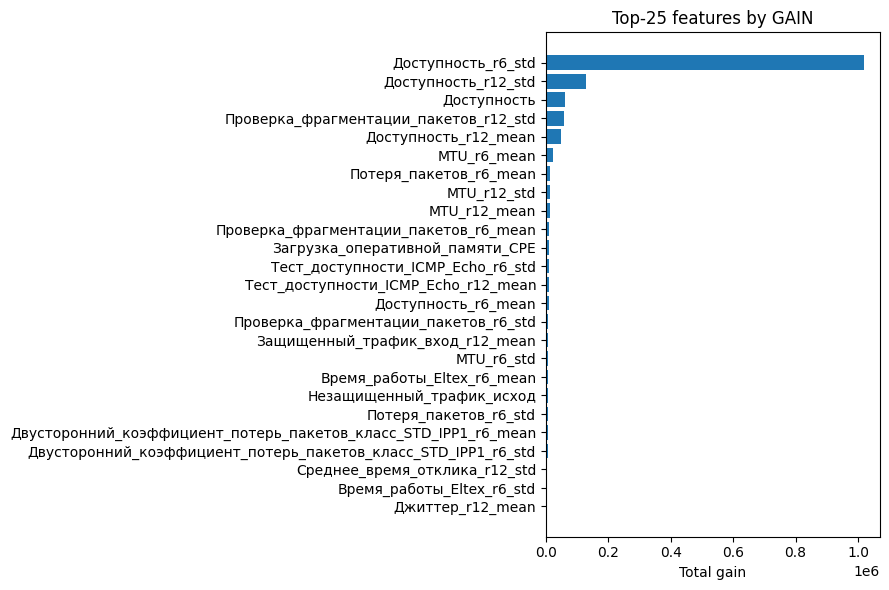


########  Доступность_r6_std  ########
Сравнительные статистики для признака 'Доступность_r6_std':


,target=0,target=1
count,2.093598e+06,22200.000000
mean,6.042875e-04,0.197580
std,9.995531e-03,0.186176
min,0.000000e+00,0.000000
25%,0.000000e+00,0.034427
50%,0.000000e+00,0.120031
75%,0.000000e+00,0.400231
max,6.599663e-01,0.547723


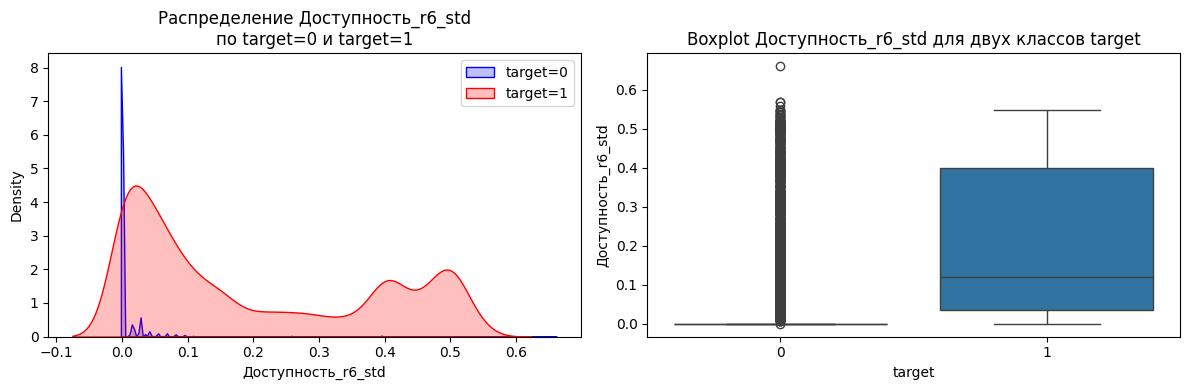


########  Доступность_r12_std  ########
Сравнительные статистики для признака 'Доступность_r12_std':


,target=0,target=1
count,2.093598e+06,22200.000000
mean,2.049978e-03,0.209147
std,2.318078e-02,0.181368
min,0.000000e+00,0.000000
25%,0.000000e+00,0.039817
50%,0.000000e+00,0.134715
75%,0.000000e+00,0.386472
max,6.599663e-01,0.522233


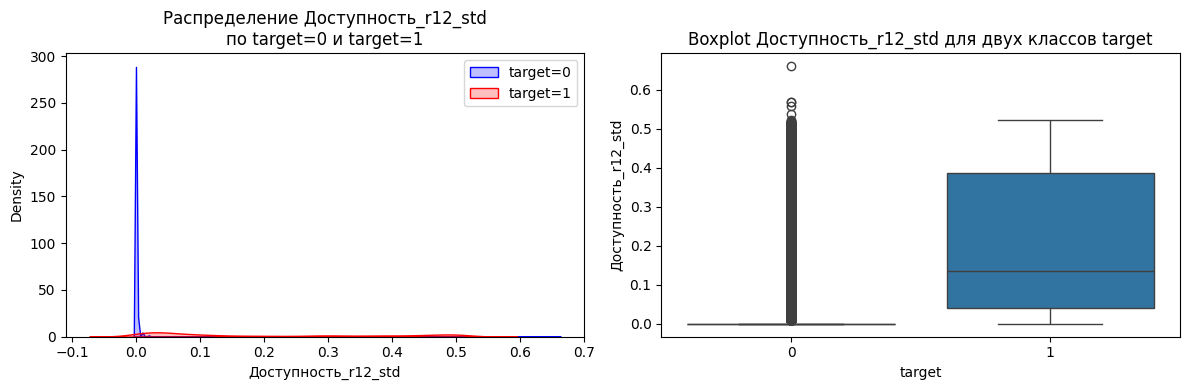


########  Доступность  ########
Сравнительные статистики для признака 'Доступность':


,target=0,target=1
count,2.094715e+06,22209.000000
mean,9.864346e-01,0.803719
std,1.141038e-01,0.371705
min,0.000000e+00,0.000000
25%,1.000000e+00,0.900000
50%,1.000000e+00,1.000000
75%,1.000000e+00,1.000000
max,1.000000e+00,1.000000


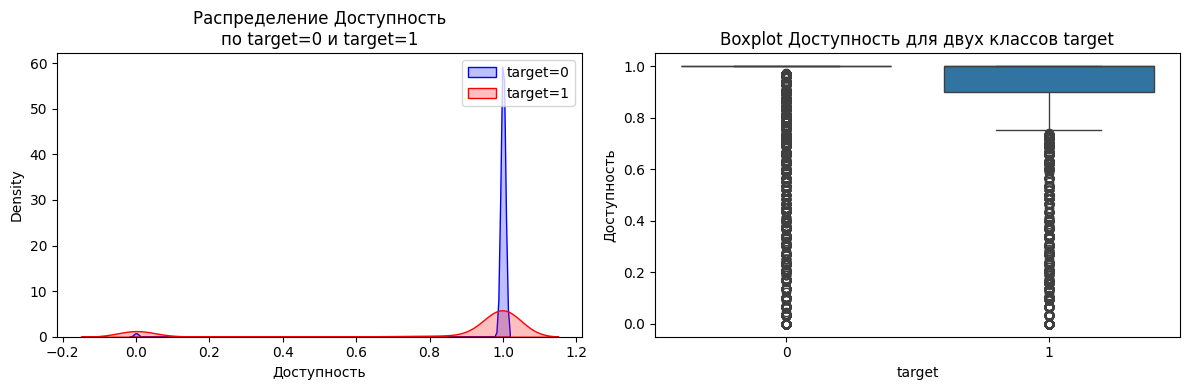


########  Проверка_фрагментации_пакетов_r12_std  ########
Сравнительные статистики для признака 'Проверка_фрагментации_пакетов_r12_std':


,target=0,target=1
count,2.090698e+06,22170.000000
mean,5.849705e-03,0.234264
std,3.598383e-02,0.179918
min,0.000000e+00,0.000000
25%,0.000000e+00,0.096225
50%,0.000000e+00,0.207194
75%,0.000000e+00,0.410305
max,7.071068e-01,0.577350


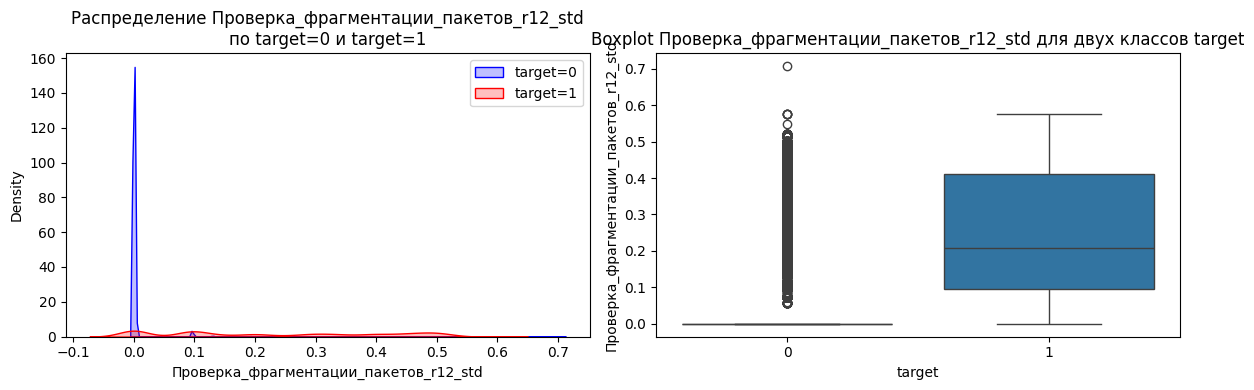


########  Доступность_r12_mean  ########
Сравнительные статистики для признака 'Доступность_r12_mean':


,target=0,target=1
count,2.094715e+06,22209.000000
mean,9.862732e-01,0.822225
std,1.127923e-01,0.228926
min,0.000000e+00,0.000000
25%,1.000000e+00,0.736111
50%,1.000000e+00,0.935069
75%,1.000000e+00,0.984028
max,1.000000e+00,1.000000


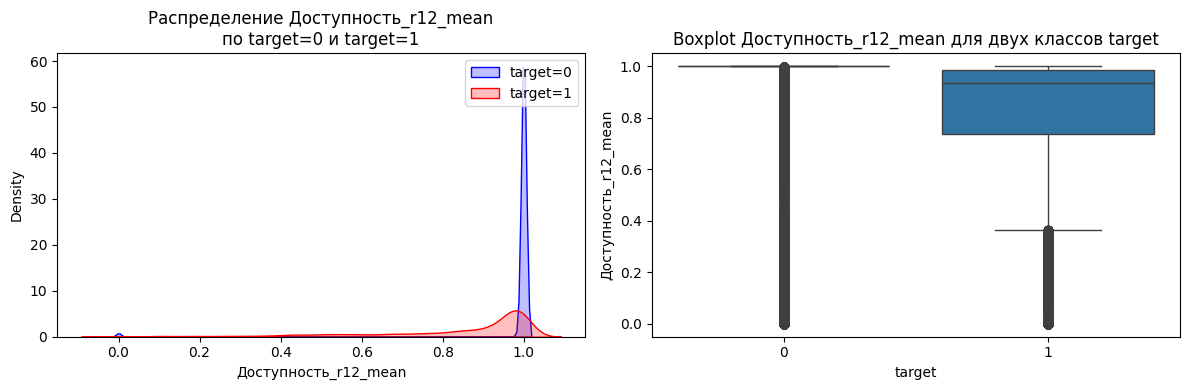


########  MTU_r6_mean  ########
Сравнительные статистики для признака 'MTU_r6_mean':


,target=0,target=1
count,2.094715e+06,22209.000000
mean,1.773279e+03,1349.693799
std,2.067130e+02,504.970849
min,0.000000e+00,0.000000
25%,1.800000e+03,1050.000000
50%,1.800000e+03,1500.000000
75%,1.800000e+03,1800.000000
max,1.800000e+03,1800.000000


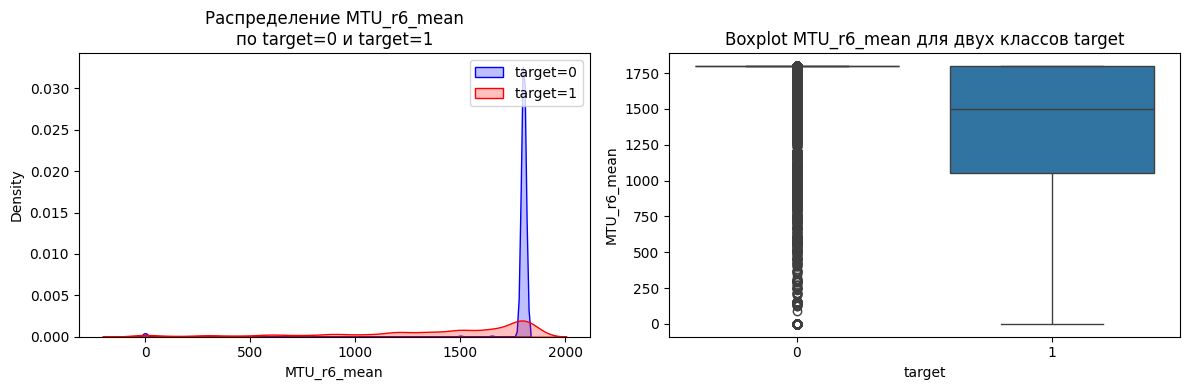


########  Потеря_пакетов_r6_mean  ########
Сравнительные статистики для признака 'Потеря_пакетов_r6_mean':


,target=0,target=1
count,1.672628e+06,17587.000000
mean,1.786971e+00,21.842958
std,1.264577e+01,27.277457
min,0.000000e+00,0.000000
25%,0.000000e+00,2.222222
50%,0.000000e+00,8.854167
75%,0.000000e+00,32.758621
max,1.000000e+02,100.000000


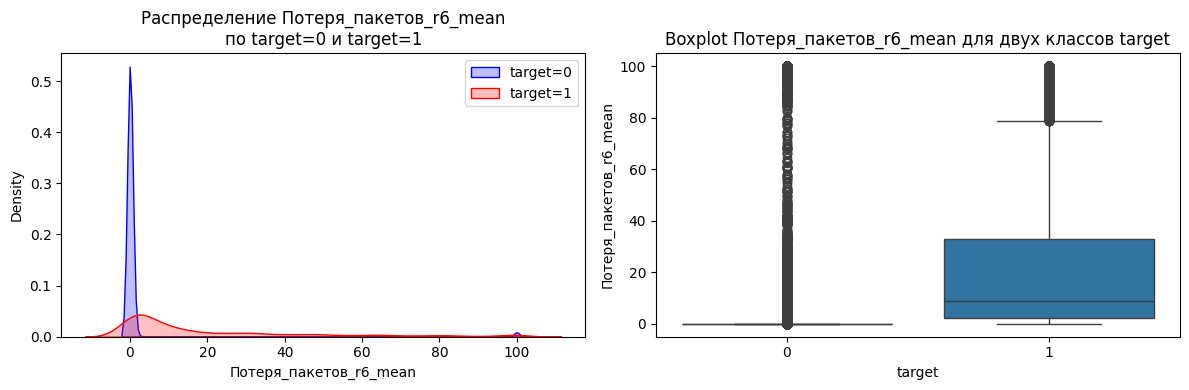


########  MTU_r12_std  ########
Сравнительные статистики для признака 'MTU_r12_std':


,target=0,target=1
count,2.093598e+06,22200.000000
mean,8.827123e+00,469.584679
std,6.880512e+01,335.507014
min,0.000000e+00,0.000000
25%,0.000000e+00,1.876388
50%,0.000000e+00,526.515365
75%,0.000000e+00,798.862828
max,1.272792e+03,1272.792206


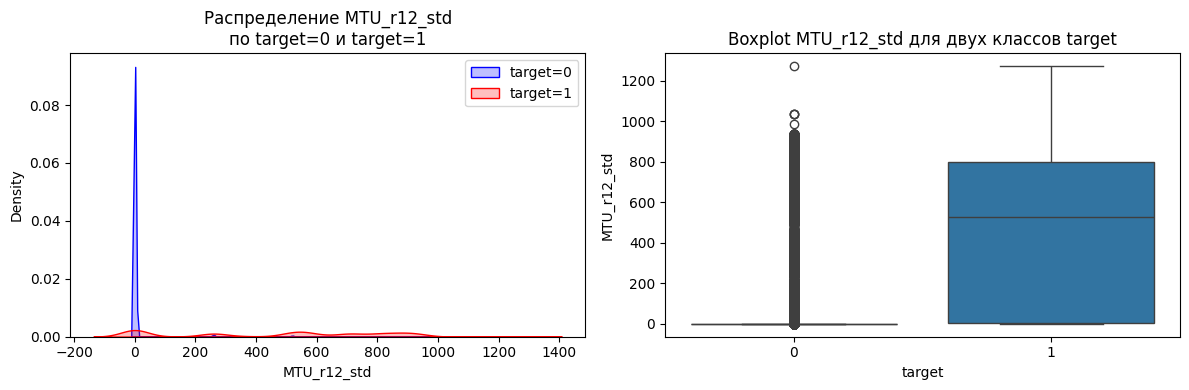


########  MTU_r12_mean  ########
Сравнительные статистики для признака 'MTU_r12_mean':


,target=0,target=1
count,2.094715e+06,22209.000000
mean,1.772424e+03,1433.551112
std,2.052305e+02,420.596292
min,0.000000e+00,0.000000
25%,1.800000e+03,1230.416667
50%,1.800000e+03,1575.000000
75%,1.800000e+03,1746.791667
max,1.800000e+03,1800.000000


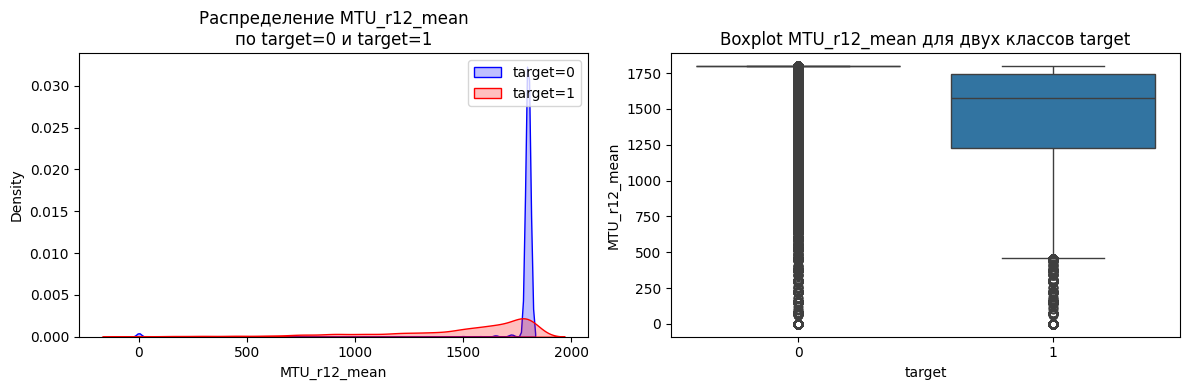


########  Проверка_фрагментации_пакетов_r6_mean  ########
Сравнительные статистики для признака 'Проверка_фрагментации_пакетов_r6_mean':


,target=0,target=1
count,2.091814e+06,22179.000000
mean,9.806735e-01,0.737163
std,1.309048e-01,0.302105
min,0.000000e+00,0.000000
25%,1.000000e+00,0.555556
50%,1.000000e+00,0.888889
75%,1.000000e+00,1.000000
max,1.000000e+00,1.000000


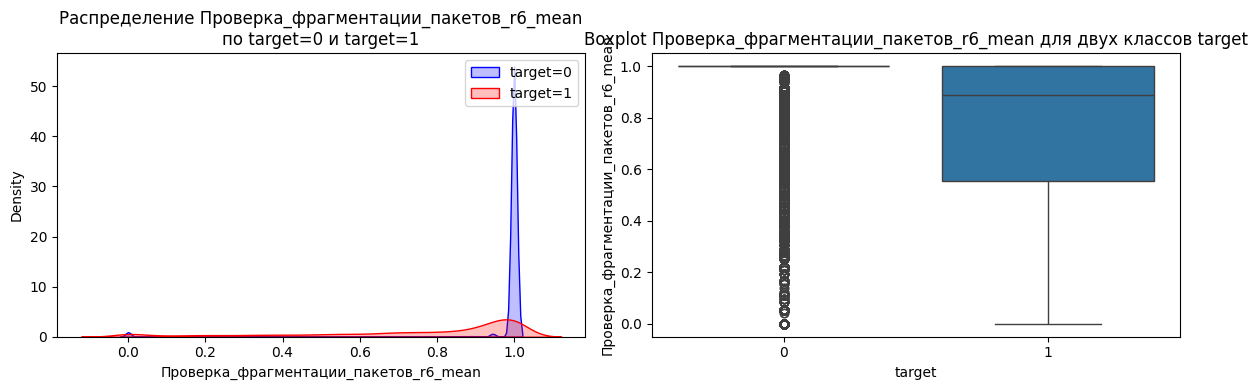

In [ ]:
# --------------------------------------------------------------
# 1. Выводим Gain-таблицу + bar-chart (функция уже есть)
# --------------------------------------------------------------
top_n = 25
imp_df = show_lgb_feature_importance(
    booster=lgb_trainer.model_,
    top_n=top_n
)

# --------------------------------------------------------------
# 2. Сравниваем распределения для первых k признаков из imp_df
# --------------------------------------------------------------
k = 10
top_feats = imp_df.head(k)["feature"].tolist()

for col in top_feats:
    print(f"\n########  {col}  ########")
    compare_distribution(
        df=train_df,             # тот же train, на котором учились
        feature_col=col,
        target_col=TARGET_COL
    )

In [26]:
df_lag = update_target_by_htf(base_df, 1)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 1 h
lgb_trainer = ModelTrainer("lgbm", n_trials=5, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex1_1h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

[I 2025-04-28 11:03:55,878] A new study created in memory with name: no-name-8bff1b5f-37bf-4b5e-b934-e10e0b0fc329


gpu_learning


[I 2025-04-28 11:05:45,784] Trial 0 finished with value: 0.9967633138942005 and parameters: {'learning_rate': 0.07291974042709126, 'num_leaves': 111, 'max_depth': 9, 'min_data_in_leaf': 67, 'feature_fraction': 0.7525157367181498, 'bagging_fraction': 0.9482178377045871, 'bagging_freq': 7}. Best is trial 0 with value: 0.9967633138942005.


gpu_learning


[I 2025-04-28 11:08:07,579] Trial 1 finished with value: 0.9971234084859525 and parameters: {'learning_rate': 0.05870106345602022, 'num_leaves': 223, 'max_depth': 7, 'min_data_in_leaf': 83, 'feature_fraction': 0.7247935255057215, 'bagging_fraction': 0.7607677347163193, 'bagging_freq': 5}. Best is trial 1 with value: 0.9971234084859525.


gpu_learning


[I 2025-04-28 11:10:28,698] Trial 2 finished with value: 0.9971148820916621 and parameters: {'learning_rate': 0.05292807073291, 'num_leaves': 63, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 0.7830849968236743, 'bagging_fraction': 0.9439205288987323, 'bagging_freq': 4}. Best is trial 1 with value: 0.9971234084859525.


gpu_learning


[I 2025-04-28 11:13:08,902] Trial 3 finished with value: 0.9969781009439022 and parameters: {'learning_rate': 0.08520609908702591, 'num_leaves': 231, 'max_depth': 8, 'min_data_in_leaf': 58, 'feature_fraction': 0.8491969007744986, 'bagging_fraction': 0.8990363552735555, 'bagging_freq': 8}. Best is trial 1 with value: 0.9971234084859525.


gpu_learning


[I 2025-04-28 11:15:11,167] Trial 4 finished with value: 0.9971400635644198 and parameters: {'learning_rate': 0.0772914573024439, 'num_leaves': 223, 'max_depth': 4, 'min_data_in_leaf': 71, 'feature_fraction': 0.9475770941299745, 'bagging_fraction': 0.90758359097698, 'bagging_freq': 3}. Best is trial 4 with value: 0.9971400635644198.


[Optuna] best AUC=0.9971
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 3h timelag ************

=== LGBM hold‑out | thr=0.50 ===
ROC‑AUC=0.9942 | F1=0.6763 | Precision=0.7131 | Recall=0.6431
              precision    recall  f1-score   support

           0      0.998     0.998     0.998    634240
           1      0.713     0.643     0.676      4054

    accuracy                          0.996    638294
   macro avg      0.855     0.821     0.837    638294
weighted avg      0.996     0.996     0.996    638294



In [ ]:
base_df = pd.read_csv("Eltex1_24h_30_min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])
df_lag = update_target_by_htf(base_df, 12)

# 2) hold-out: декабрь = тест
train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

## Eltex2

In [31]:
# %% ---------------------- SETUP -------------------------------------
# (1) базовый датасет с 30-минутным шагом и initial target-24h
base_df = pd.read_csv("Eltex2_24h_30_min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])

# (2) таблица инцидентов
inc_df = load_incidents(INCIDENTS_PATH)

# (3) Δt до ближайшей будущей аварии (0 – 24 h); считаем ОДИН раз
base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

# --------- эксперименты с разными горизонтами ------------------------
timelags = [12, 6, 5, 4, 3, 2]          # часов до отказа
results  = {}

for lag in timelags:
    print(f"\n##########  {lag} hours to fail  ##########")

    # 1) обновляем target (включительно ≤ lag)
    df_lag = update_target_by_htf(base_df, lag)

    # 2) hold-out: декабрь = тест
    train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
    FEATURES = [
        c for c in train_df.columns
        if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
    ]

    # 3) обучаем LightGBM (3 Optuna-trial для скорости)
    trainer = ModelTrainer(
        model_type="lgbm",
        n_trials=5,
        cv_splits=3,
    )
    trainer.fit(train_df, FEATURES, test_df, device=f"Eltex2_{lag}h")

    # 4) метрики на hold-out
    metrics_lag = trainer.evaluate(
        test_df, FEATURES,
        tag=f"LGBM hold-out {lag}h"
    )

    # 5) coverage-анализ по hours_to_fail
    test_df = test_df.copy()
    test_df["y_pred"] = trainer.predict(test_df[FEATURES])
    cov_tbl = evaluate_coverage(test_df)

    # 7) сохраняем результаты цикла
    results[lag] = {"metrics": metrics_lag, "coverage": cov_tbl}


##########  12 hours to fail  ##########


[I 2025-04-27 22:26:17,384] A new study created in memory with name: no-name-a03c698e-9cd5-432a-97d4-98516e4d99dd
[I 2025-04-27 22:27:16,329] Trial 0 finished with value: 0.7471463691223038 and parameters: {'learning_rate': 0.0660909846383257, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 33, 'feature_fraction': 0.8898202184582278, 'bagging_fraction': 0.9382526331540209, 'bagging_freq': 5}. Best is trial 0 with value: 0.7471463691223038.
[I 2025-04-27 22:30:34,056] Trial 1 finished with value: 0.749827991149768 and parameters: {'learning_rate': 0.006378721700079336, 'num_leaves': 71, 'max_depth': 7, 'min_data_in_leaf': 66, 'feature_fraction': 0.832483874062623, 'bagging_fraction': 0.8933546499480822, 'bagging_freq': 2}. Best is trial 1 with value: 0.749827991149768.
[I 2025-04-27 22:34:13,187] Trial 2 finished with value: 0.7449600678395655 and parameters: {'learning_rate': 0.0011516710839182653, 'num_leaves': 143, 'max_depth': 6, 'min_data_in_leaf': 94, 'feature_fraction': 0.7

[Optuna] best AUC=0.7498
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 12h | thr=0.50 ===
ROC‑AUC=0.7280 | F1=0.4253 | Precision=0.8313 | Recall=0.2858
              precision    recall  f1-score   support

           0      0.970     0.997     0.983    722653
           1      0.831     0.286     0.425     31329

    accuracy                          0.968    753982
   macro avg      0.901     0.642     0.704    753982
weighted avg      0.964     0.968     0.960    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,2448,72.6
1,2758,2390,86.7
2,2574,2223,86.4
3,2448,1121,45.8
4,2385,197,8.3
5,2331,142,6.1
6,2292,104,4.5
7,2256,77,3.4
8,2225,68,3.1



##########  6 hours to fail  ##########


[I 2025-04-27 22:41:52,008] A new study created in memory with name: no-name-ca78fb13-f1e4-4f5e-b37e-304ab656a33b
[I 2025-04-27 22:42:52,936] Trial 0 finished with value: 0.8495222159911019 and parameters: {'learning_rate': 0.07435993921680441, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 39, 'feature_fraction': 0.8101621815731039, 'bagging_fraction': 0.8855965752954459, 'bagging_freq': 2}. Best is trial 0 with value: 0.8495222159911019.
[I 2025-04-27 22:46:03,743] Trial 1 finished with value: 0.8500735589535736 and parameters: {'learning_rate': 0.007356644851738607, 'num_leaves': 159, 'max_depth': 10, 'min_data_in_leaf': 87, 'feature_fraction': 0.7157189094233586, 'bagging_fraction': 0.9104294627393953, 'bagging_freq': 8}. Best is trial 1 with value: 0.8500735589535736.
[I 2025-04-27 22:49:53,754] Trial 2 finished with value: 0.847019287286793 and parameters: {'learning_rate': 0.0010082273899646524, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 66, 'feature_fraction

[Optuna] best AUC=0.8501
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 6h | thr=0.50 ===
ROC‑AUC=0.8316 | F1=0.0000 | Precision=0.0000 | Recall=0.0000
              precision    recall  f1-score   support

           0      0.976     1.000     0.988    735821
           1      0.000     0.000     0.000     18161

    accuracy                          0.976    753982
   macro avg      0.488     0.500     0.494    753982
weighted avg      0.952     0.976     0.964    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,0,0.0
1,2758,0,0.0
2,2574,0,0.0
3,2448,0,0.0
4,2385,0,0.0
5,2331,0,0.0
6,2292,0,0.0
7,2256,0,0.0
8,2225,0,0.0



##########  5 hours to fail  ##########


[I 2025-04-27 22:53:57,973] A new study created in memory with name: no-name-df77038f-085c-4ed9-9d19-047d54b3c575
[I 2025-04-27 22:56:37,327] Trial 0 finished with value: 0.8781583678359389 and parameters: {'learning_rate': 0.003791056823799716, 'num_leaves': 199, 'max_depth': 10, 'min_data_in_leaf': 47, 'feature_fraction': 0.8542016553301549, 'bagging_fraction': 0.9733519031384785, 'bagging_freq': 3}. Best is trial 0 with value: 0.8781583678359389.
[I 2025-04-27 22:57:39,081] Trial 1 finished with value: 0.8797864969953176 and parameters: {'learning_rate': 0.07301851038958465, 'num_leaves': 39, 'max_depth': 6, 'min_data_in_leaf': 77, 'feature_fraction': 0.81702490004926, 'bagging_fraction': 0.8367675997404718, 'bagging_freq': 8}. Best is trial 1 with value: 0.8797864969953176.
[I 2025-04-27 22:59:54,505] Trial 2 finished with value: 0.8796212566579218 and parameters: {'learning_rate': 0.015067219963098096, 'num_leaves': 255, 'max_depth': 9, 'min_data_in_leaf': 62, 'feature_fraction': 

[Optuna] best AUC=0.8798
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 5h | thr=0.50 ===
ROC‑AUC=0.8639 | F1=0.6292 | Precision=0.8890 | Recall=0.4869
              precision    recall  f1-score   support

           0      0.989     0.999     0.994    738113
           1      0.889     0.487     0.629     15869

    accuracy                          0.988    753982
   macro avg      0.939     0.743     0.812    753982
weighted avg      0.987     0.988     0.986    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,2321,68.8
1,2758,2265,82.1
2,2574,2086,81.0
3,2448,947,38.7
4,2385,66,2.8
5,2331,41,1.8
6,2292,30,1.3
7,2256,31,1.4
8,2225,13,0.6



##########  4 hours to fail  ##########


[I 2025-04-27 23:05:55,051] A new study created in memory with name: no-name-4f8d4935-9073-4ae6-ab96-304d491277d6
[I 2025-04-27 23:09:47,005] Trial 0 finished with value: 0.9092410687618937 and parameters: {'learning_rate': 0.0012799534696554108, 'num_leaves': 175, 'max_depth': 6, 'min_data_in_leaf': 84, 'feature_fraction': 0.7638959182254902, 'bagging_fraction': 0.9883098659929437, 'bagging_freq': 9}. Best is trial 0 with value: 0.9092410687618937.
[I 2025-04-27 23:13:43,601] Trial 1 finished with value: 0.9122436570324312 and parameters: {'learning_rate': 0.0018004593862239611, 'num_leaves': 87, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.7257663184467592, 'bagging_fraction': 0.7616269854865683, 'bagging_freq': 5}. Best is trial 1 with value: 0.9122436570324312.
[I 2025-04-27 23:14:47,759] Trial 2 finished with value: 0.9139341548183122 and parameters: {'learning_rate': 0.07828390736237721, 'num_leaves': 167, 'max_depth': 5, 'min_data_in_leaf': 29, 'feature_fraction

[Optuna] best AUC=0.9159
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 4h | thr=0.50 ===
ROC‑AUC=0.9049 | F1=0.7003 | Precision=0.8714 | Recall=0.5854
              precision    recall  f1-score   support

           0      0.992     0.998     0.995    740444
           1      0.871     0.585     0.700     13538

    accuracy                          0.991    753982
   macro avg      0.932     0.792     0.848    753982
weighted avg      0.990     0.991     0.990    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,2375,70.4
1,2758,2346,85.1
2,2574,2142,83.2
3,2448,994,40.6
4,2385,68,2.9
5,2331,43,1.8
6,2292,32,1.4
7,2256,31,1.4
8,2225,19,0.9



##########  3 hours to fail  ##########


[I 2025-04-27 23:17:53,451] A new study created in memory with name: no-name-a0a25927-ca0d-4cbc-85a8-b56e89ddf750
[I 2025-04-27 23:19:43,832] Trial 0 finished with value: 0.9648887653671037 and parameters: {'learning_rate': 0.01957627142538875, 'num_leaves': 47, 'max_depth': 8, 'min_data_in_leaf': 96, 'feature_fraction': 0.7109534383053291, 'bagging_fraction': 0.8629740944611553, 'bagging_freq': 3}. Best is trial 0 with value: 0.9648887653671037.
[I 2025-04-27 23:23:24,803] Trial 1 finished with value: 0.9615858714671545 and parameters: {'learning_rate': 0.0023469142121640323, 'num_leaves': 95, 'max_depth': 9, 'min_data_in_leaf': 81, 'feature_fraction': 0.8904323248294537, 'bagging_fraction': 0.7645449225035774, 'bagging_freq': 8}. Best is trial 0 with value: 0.9648887653671037.
[I 2025-04-27 23:24:30,680] Trial 2 finished with value: 0.9638966547874448 and parameters: {'learning_rate': 0.05595383747995758, 'num_leaves': 87, 'max_depth': 6, 'min_data_in_leaf': 84, 'feature_fraction': 0

[Optuna] best AUC=0.9649
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 3h | thr=0.50 ===
ROC‑AUC=0.9610 | F1=0.7771 | Precision=0.8924 | Recall=0.6882
              precision    recall  f1-score   support

           0      0.995     0.999     0.997    742829
           1      0.892     0.688     0.777     11153

    accuracy                          0.994    753982
   macro avg      0.944     0.843     0.887    753982
weighted avg      0.994     0.994     0.994    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,2329,69.0
1,2758,2298,83.3
2,2574,2103,81.7
3,2448,946,38.6
4,2385,46,1.9
5,2331,27,1.2
6,2292,22,1.0
7,2256,18,0.8
8,2225,7,0.3



##########  2 hours to fail  ##########


[I 2025-04-27 23:28:11,457] A new study created in memory with name: no-name-5a8e954c-5fb9-4bf4-a766-27cf1130c1e0
[I 2025-04-27 23:33:05,849] Trial 0 finished with value: 0.9955822701335851 and parameters: {'learning_rate': 0.003785657237011959, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 54, 'feature_fraction': 0.9861079436477892, 'bagging_fraction': 0.7416260366472347, 'bagging_freq': 7}. Best is trial 0 with value: 0.9955822701335851.
[I 2025-04-27 23:37:34,125] Trial 1 finished with value: 0.9951326796309775 and parameters: {'learning_rate': 0.0018895554296768265, 'num_leaves': 111, 'max_depth': 4, 'min_data_in_leaf': 91, 'feature_fraction': 0.7800234457823237, 'bagging_fraction': 0.8271043586101919, 'bagging_freq': 5}. Best is trial 0 with value: 0.9955822701335851.
[I 2025-04-27 23:39:38,179] Trial 2 finished with value: 0.9931340585396989 and parameters: {'learning_rate': 0.004563898898513471, 'num_leaves': 71, 'max_depth': 7, 'min_data_in_leaf': 78, 'feature_fraction'

[Optuna] best AUC=0.9956
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 2h | thr=0.50 ===
ROC‑AUC=0.9939 | F1=0.7548 | Precision=0.8931 | Recall=0.6536
              precision    recall  f1-score   support

           0      0.996     0.999     0.998    745277
           1      0.893     0.654     0.755      8705

    accuracy                          0.995    753982
   macro avg      0.945     0.826     0.876    753982
weighted avg      0.995     0.995     0.995    753982



,need,pred,recall_%
hours_to_fail,,,
0,3373,2029,60.2
1,2758,2025,73.4
2,2574,1636,63.6
3,2448,103,4.2
4,2385,24,1.0
5,2331,20,0.9
6,2292,18,0.8
7,2256,9,0.4
8,2225,4,0.2


In [15]:
base_df = pd.read_csv("Eltex2_24h_30_min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])
inc_df = load_incidents(INCIDENTS_PATH)

base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

In [ ]:
df_lag = update_target_by_htf(base_df, 3)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 3 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex2_3h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

[I 2025-04-28 11:36:14,092] A new study created in memory with name: no-name-00c2f44a-02cb-42c7-a76d-e9370446984a


gpu_learning


[I 2025-04-28 11:37:31,574] Trial 0 finished with value: 0.9638164057872842 and parameters: {'learning_rate': 0.05010355412204189, 'num_leaves': 143, 'max_depth': 9, 'min_data_in_leaf': 85, 'feature_fraction': 0.8836066747508394, 'bagging_fraction': 0.764780677625936, 'bagging_freq': 5}. Best is trial 0 with value: 0.9638164057872842.


gpu_learning


[I 2025-04-28 11:38:46,831] Trial 1 finished with value: 0.9634859472748732 and parameters: {'learning_rate': 0.05005400332800189, 'num_leaves': 135, 'max_depth': 4, 'min_data_in_leaf': 57, 'feature_fraction': 0.8108417686230237, 'bagging_fraction': 0.8562850772628852, 'bagging_freq': 9}. Best is trial 0 with value: 0.9638164057872842.


gpu_learning


[I 2025-04-28 11:39:55,514] Trial 2 finished with value: 0.9640643601574962 and parameters: {'learning_rate': 0.05035714312455905, 'num_leaves': 87, 'max_depth': 8, 'min_data_in_leaf': 53, 'feature_fraction': 0.8489813177160641, 'bagging_fraction': 0.9447604740143627, 'bagging_freq': 8}. Best is trial 2 with value: 0.9640643601574962.


[Optuna] best AUC=0.9641
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 3h timelag ************

=== LGBM hold‑out | thr=0.50 ===
ROC‑AUC=0.9608 | F1=0.7825 | Precision=0.8788 | Recall=0.7052
              precision    recall  f1-score   support

           0      0.996     0.999     0.997    742829
           1      0.879     0.705     0.782     11153

    accuracy                          0.994    753982
   macro avg      0.937     0.852     0.890    753982
weighted avg      0.994     0.994     0.994    753982



In [16]:
df_lag = update_target_by_htf(base_df, 2)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-15")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 2 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex2_2h')
print("************ 2h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

[I 2025-06-11 01:43:32,372] A new study created in memory with name: no-name-840a18fd-f844-4f75-977a-3847ade2a951
[I 2025-06-11 01:45:05,564] Trial 0 finished with value: 0.9956524219528372 and parameters: {'learning_rate': 0.07066680385149969, 'num_leaves': 199, 'max_depth': 10, 'min_data_in_leaf': 64, 'feature_fraction': 0.9756176892187696, 'bagging_fraction': 0.8265177337113762, 'bagging_freq': 9}. Best is trial 0 with value: 0.9956524219528372.
[I 2025-06-11 01:46:10,506] Trial 1 finished with value: 0.9960299579415971 and parameters: {'learning_rate': 0.054562235681627574, 'num_leaves': 63, 'max_depth': 9, 'min_data_in_leaf': 37, 'feature_fraction': 0.7326884686416442, 'bagging_fraction': 0.8670985861711944, 'bagging_freq': 8}. Best is trial 1 with value: 0.9960299579415971.
[I 2025-06-11 01:47:18,635] Trial 2 finished with value: 0.9958716204465111 and parameters: {'learning_rate': 0.06082043630647588, 'num_leaves': 183, 'max_depth': 6, 'min_data_in_leaf': 30, 'feature_fraction':

[Optuna] best AUC=0.9960
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models
************ 2h timelag ************

=== LGBM hold‑out | thr=0.50 ===
ROC‑AUC=0.9948 | F1=0.8117 | Precision=0.8745 | Recall=0.7573
              precision    recall  f1-score   support

           0      0.997     0.999     0.998    409311
           1      0.875     0.757     0.812      4639

    accuracy                          0.996    413950
   macro avg      0.936     0.878     0.905    413950
weighted avg      0.996     0.996     0.996    413950




>>> FEATURE IMPORTANCE (LightGBM)


,feature,gain,split,gain_%,split_%
192,Пропускная_способность_передача_r12_std_2,3.783282e+07,23,36.92,0.39
92,Коэффициент_загрузки_канала_прием_r6_std,2.959161e+07,20,28.88,0.34
14,Загрузка_канала_передача_Кбит_с,1.123394e+07,7,10.96,0.12
25,Незащищенный_трафик_исход,9.241707e+06,7,9.02,0.12
206,Статус_Uplink_порта_CPE_Eltex_Резервный_r12_std,5.548927e+06,17,5.42,0.29
57,Двусторонняя_вариация_времени_задержки_класс_R...,1.846266e+06,10,1.80,0.17
141,Двусторонний_коэффициент_потерь_пакетов_класс_...,1.605819e+06,25,1.57,0.43
68,Доступность_r6_std,9.701095e+05,118,0.95,2.01
158,Доступность_r12_std,8.236472e+05,217,0.80,3.69
180,Коэффициент_загрузки_канала_передача_r12_std,5.601627e+05,26,0.55,0.44


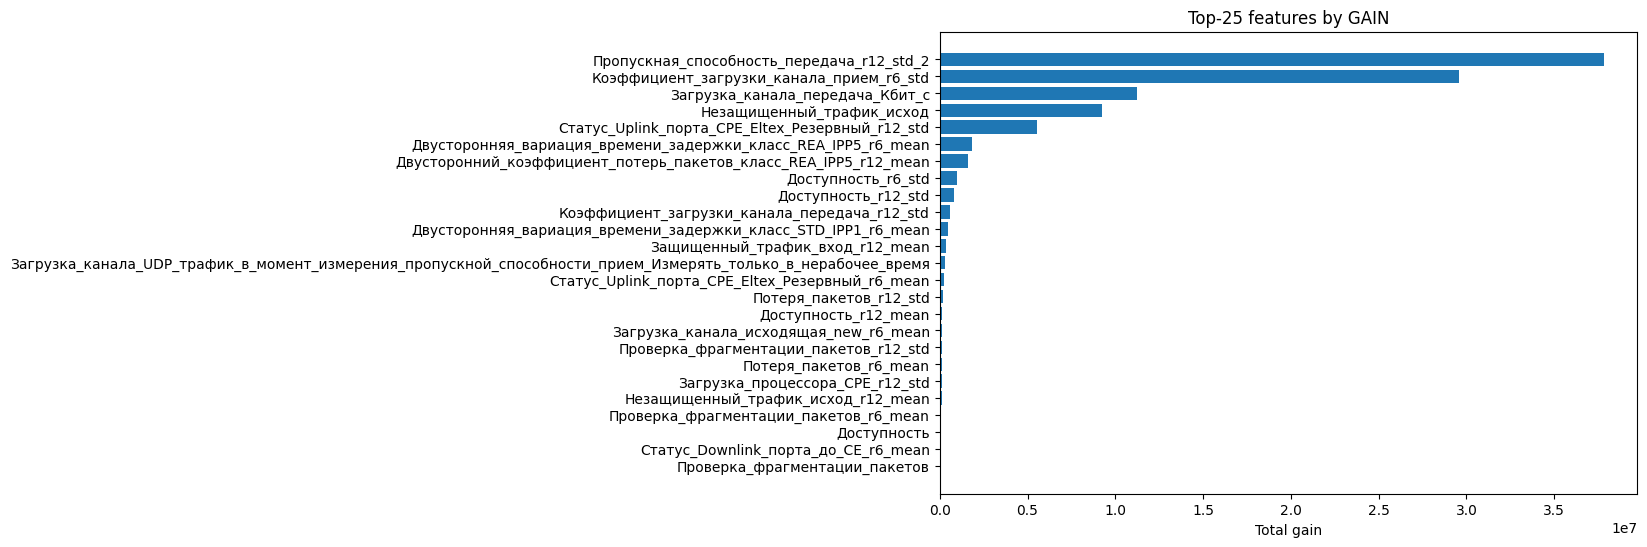


>>> SHAP SUMMARY (top-25)


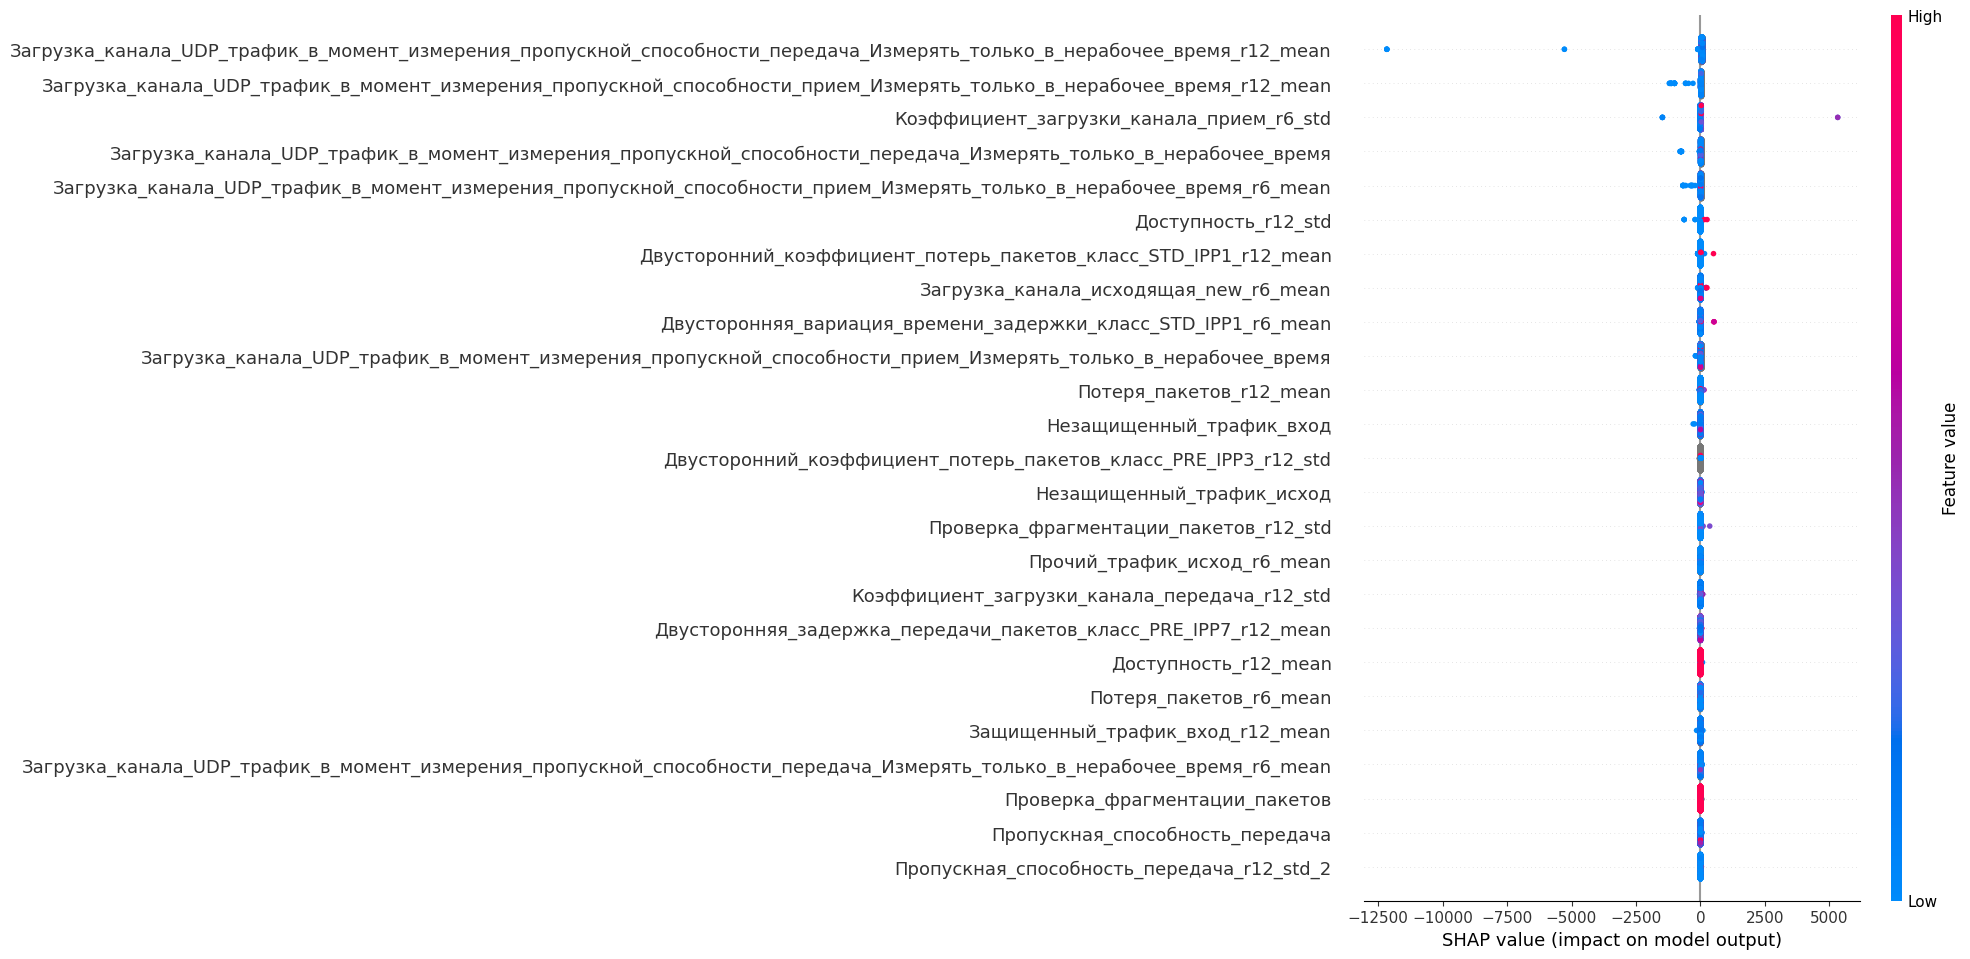

(<shap.explainers._tree.TreeExplainer at 0x7f875f692a00>,
 [array([[ 2.20809346e-03,  9.00399317e-03,  9.71729894e-06, ...,
           0.00000000e+00,  6.51843214e-06, -6.50881898e-05],
         [ 1.97657401e-03,  5.31405667e-03, -1.52205012e-02, ...,
           0.00000000e+00,  6.51843214e-06, -7.11346635e-05],
         [ 2.19735523e-03,  6.28803774e-01,  8.07540320e-06, ...,
           0.00000000e+00,  6.51843214e-06, -7.11346635e-05],
         ...,
         [ 2.19946352e-03,  9.18379586e-03,  8.07540320e-06, ...,
           0.00000000e+00,  6.51843214e-06, -7.31050272e-05],
         [ 1.94549975e-03,  5.30801833e-03,  7.85864265e-06, ...,
           0.00000000e+00,  3.70242504e-06, -6.50881898e-05],
         [ 1.94608394e-03,  5.51326646e-03,  9.74117057e-06, ...,
           0.00000000e+00,  6.51843214e-06, -6.89429307e-05]]),
  array([[-2.20809346e-03, -9.00399317e-03, -9.71729894e-06, ...,
           0.00000000e+00, -6.51843214e-06,  6.50881898e-05],
         [-1.97657401e-03, -5.

In [33]:
run_full_lgb_explain(
    lgb_trainer.model_,
    train_df[FEATURES],
    top_n=25,
    sample_size=1500
)

In [ ]:
df_lag = update_target_by_htf(base_df, 1)

train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
FEATURES = [
    c for c in train_df.columns
    if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
]

# MACHINE LEARNING ELTEX1 2 h
lgb_trainer = ModelTrainer("lgbm", n_trials=3, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex2_1h')
print("************ 1h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

## TERRA

In [53]:
# %% ---------------------- SETUP -------------------------------------
# (1) базовый датасет с 15-минутным шагом и initial target-24h
base_df = pd.read_csv("terra1_24h_15min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])

# (2) таблица инцидентов
inc_df = load_incidents(INCIDENTS_PATH)

# (3) Δt до ближайшей будущей аварии (0 – 24 h); считаем ОДИН раз
base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

# --------- эксперименты с разными горизонтами ------------------------
timelags = [12, 6, 5, 4, 3, 2]          # часов до отказа
results  = {}

for lag in timelags:
    print(f"\n##########  {lag} hours to fail  ##########")

    # 1) обновляем target (включительно ≤ lag)
    df_lag = update_target_by_htf(base_df, lag)

    # 2) hold-out: декабрь = тест
    train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
    FEATURES = [
        c for c in train_df.columns
        if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
    ]

    # 3) обучаем LightGBM (3 Optuna-trial для скорости)
    trainer = ModelTrainer(
        model_type="lgbm",
        n_trials=5,
        cv_splits=3,
    )
    trainer.fit(train_df, FEATURES, test_df, device=f"terra1_{lag}h")

    # 4) метрики на hold-out
    metrics_lag = trainer.evaluate(
        test_df, FEATURES,
        tag=f"LGBM hold-out {lag}h"
    )

    # 5) coverage-анализ по hours_to_fail
    test_df = test_df.copy()
    test_df["y_pred"] = trainer.predict(test_df[FEATURES])
    cov_tbl = evaluate_coverage(test_df)

    # 7) сохраняем результаты цикла
    results[lag] = {"metrics": metrics_lag, "coverage": cov_tbl}


##########  12 hours to fail  ##########


[I 2025-04-28 01:38:51,360] A new study created in memory with name: no-name-4470fb65-6cbc-4dbf-b86c-c4ecfc398cae


gpu_learning


[I 2025-04-28 01:39:04,323] Trial 0 finished with value: 0.7198553468734518 and parameters: {'learning_rate': 0.012063398580321223, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 31, 'feature_fraction': 0.7699260531569653, 'bagging_fraction': 0.9271048156066796, 'bagging_freq': 1}. Best is trial 0 with value: 0.7198553468734518.


gpu_learning


[I 2025-04-28 01:39:43,614] Trial 1 finished with value: 0.7104971838197901 and parameters: {'learning_rate': 0.04614802125941962, 'num_leaves': 207, 'max_depth': 10, 'min_data_in_leaf': 49, 'feature_fraction': 0.9247257925263185, 'bagging_fraction': 0.8109361820046783, 'bagging_freq': 5}. Best is trial 0 with value: 0.7198553468734518.


gpu_learning


[I 2025-04-28 01:40:36,521] Trial 2 finished with value: 0.7264601623168256 and parameters: {'learning_rate': 0.011776182614143725, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 76, 'feature_fraction': 0.8504613775306502, 'bagging_fraction': 0.9526544816558205, 'bagging_freq': 2}. Best is trial 2 with value: 0.7264601623168256.


gpu_learning


[I 2025-04-28 01:40:51,560] Trial 3 finished with value: 0.7211059667189662 and parameters: {'learning_rate': 0.020474738786426555, 'num_leaves': 111, 'max_depth': 6, 'min_data_in_leaf': 24, 'feature_fraction': 0.7977516583992459, 'bagging_fraction': 0.8959876921425394, 'bagging_freq': 5}. Best is trial 2 with value: 0.7264601623168256.


gpu_learning


[I 2025-04-28 01:41:05,081] Trial 4 finished with value: 0.7119638789867887 and parameters: {'learning_rate': 0.0014084099416949946, 'num_leaves': 31, 'max_depth': 4, 'min_data_in_leaf': 20, 'feature_fraction': 0.7168235013124654, 'bagging_fraction': 0.7616635176271909, 'bagging_freq': 6}. Best is trial 2 with value: 0.7264601623168256.


[Optuna] best AUC=0.7265
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 12h | thr=0.50 ===
ROC‑AUC=0.7363 | F1=0.0337 | Precision=0.9932 | Recall=0.0172
              precision    recall  f1-score   support

           0      0.975     1.000     0.987    327315
           1      0.993     0.017     0.034      8447

    accuracy                          0.975    335762
   macro avg      0.984     0.509     0.511    335762
weighted avg      0.976     0.975     0.963    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,10,1.2
1,675,54,8.0
2,660,75,11.4
3,646,5,0.8
4,644,0,0.0
5,640,1,0.2
6,637,0,0.0
7,630,0,0.0
8,624,0,0.0



##########  6 hours to fail  ##########


[I 2025-04-28 01:41:15,884] A new study created in memory with name: no-name-afde0342-025c-4b97-ad3f-82bbd53ec6ab


gpu_learning


[I 2025-04-28 01:41:33,107] Trial 0 finished with value: 0.7869519908603845 and parameters: {'learning_rate': 0.0036132589012122587, 'num_leaves': 71, 'max_depth': 4, 'min_data_in_leaf': 44, 'feature_fraction': 0.7920296485247806, 'bagging_fraction': 0.9285717909746481, 'bagging_freq': 1}. Best is trial 0 with value: 0.7869519908603845.


gpu_learning


[I 2025-04-28 01:42:09,018] Trial 1 finished with value: 0.7837665145461864 and parameters: {'learning_rate': 0.0073032280578664375, 'num_leaves': 223, 'max_depth': 10, 'min_data_in_leaf': 30, 'feature_fraction': 0.8011108936793716, 'bagging_fraction': 0.8365405821101461, 'bagging_freq': 2}. Best is trial 0 with value: 0.7869519908603845.


gpu_learning


[I 2025-04-28 01:42:31,561] Trial 2 finished with value: 0.786873297281223 and parameters: {'learning_rate': 0.002689670689285912, 'num_leaves': 191, 'max_depth': 5, 'min_data_in_leaf': 84, 'feature_fraction': 0.8002474678048449, 'bagging_fraction': 0.8250003410427554, 'bagging_freq': 7}. Best is trial 0 with value: 0.7869519908603845.


gpu_learning


[I 2025-04-28 01:42:59,364] Trial 3 finished with value: 0.7855730954628933 and parameters: {'learning_rate': 0.02877346411391552, 'num_leaves': 39, 'max_depth': 6, 'min_data_in_leaf': 35, 'feature_fraction': 0.9945811986552955, 'bagging_fraction': 0.9217585626956033, 'bagging_freq': 2}. Best is trial 0 with value: 0.7869519908603845.


gpu_learning


[I 2025-04-28 01:43:27,449] Trial 4 finished with value: 0.772257245691306 and parameters: {'learning_rate': 0.021106348328799627, 'num_leaves': 175, 'max_depth': 10, 'min_data_in_leaf': 31, 'feature_fraction': 0.8618595839138408, 'bagging_fraction': 0.8519921866358078, 'bagging_freq': 6}. Best is trial 0 with value: 0.7869519908603845.


[Optuna] best AUC=0.7870
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 6h | thr=0.50 ===
ROC‑AUC=0.8010 | F1=0.0000 | Precision=0.0000 | Recall=0.0000
              precision    recall  f1-score   support

           0      0.986     1.000     0.993    331036
           1      0.000     0.000     0.000      4726

    accuracy                          0.986    335762
   macro avg      0.493     0.500     0.496    335762
weighted avg      0.972     0.986     0.979    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,0,0.0
1,675,0,0.0
2,660,0,0.0
3,646,0,0.0
4,644,0,0.0
5,640,0,0.0
6,637,0,0.0
7,630,0,0.0
8,624,0,0.0



##########  5 hours to fail  ##########


[I 2025-04-28 01:43:32,503] A new study created in memory with name: no-name-d70facf1-9786-4998-8b6c-f918c1325586


gpu_learning


[I 2025-04-28 01:43:47,419] Trial 0 finished with value: 0.8051782899105527 and parameters: {'learning_rate': 0.03368209395711452, 'num_leaves': 47, 'max_depth': 8, 'min_data_in_leaf': 77, 'feature_fraction': 0.8626264336161007, 'bagging_fraction': 0.9971709612433272, 'bagging_freq': 10}. Best is trial 0 with value: 0.8051782899105527.


gpu_learning


[I 2025-04-28 01:44:00,883] Trial 1 finished with value: 0.8102867055224481 and parameters: {'learning_rate': 0.011233290852906874, 'num_leaves': 103, 'max_depth': 6, 'min_data_in_leaf': 51, 'feature_fraction': 0.8766495188840202, 'bagging_fraction': 0.8075087964778177, 'bagging_freq': 10}. Best is trial 1 with value: 0.8102867055224481.


gpu_learning


[I 2025-04-28 01:44:34,554] Trial 2 finished with value: 0.801371703011586 and parameters: {'learning_rate': 0.007212726938589703, 'num_leaves': 247, 'max_depth': 10, 'min_data_in_leaf': 87, 'feature_fraction': 0.853221862012953, 'bagging_fraction': 0.9016721181488536, 'bagging_freq': 7}. Best is trial 1 with value: 0.8102867055224481.


gpu_learning


[I 2025-04-28 01:45:00,853] Trial 3 finished with value: 0.8093789554109799 and parameters: {'learning_rate': 0.03440532759630332, 'num_leaves': 39, 'max_depth': 5, 'min_data_in_leaf': 30, 'feature_fraction': 0.9173520366406941, 'bagging_fraction': 0.9939277964990886, 'bagging_freq': 3}. Best is trial 1 with value: 0.8102867055224481.


gpu_learning


[I 2025-04-28 01:45:40,376] Trial 4 finished with value: 0.8046992472752835 and parameters: {'learning_rate': 0.001472824467854846, 'num_leaves': 159, 'max_depth': 9, 'min_data_in_leaf': 46, 'feature_fraction': 0.8329175031068241, 'bagging_fraction': 0.9360210288987743, 'bagging_freq': 10}. Best is trial 1 with value: 0.8102867055224481.


[Optuna] best AUC=0.8103
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 5h | thr=0.50 ===
ROC‑AUC=0.8246 | F1=0.3153 | Precision=0.4971 | Recall=0.2309
              precision    recall  f1-score   support

           0      0.991     0.997     0.994    331673
           1      0.497     0.231     0.315      4089

    accuracy                          0.988    335762
   macro avg      0.744     0.614     0.655    335762
weighted avg      0.985     0.988     0.986    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,200,24.3
1,675,323,47.9
2,660,298,45.2
3,646,92,14.2
4,644,23,3.6
5,640,8,1.2
6,637,5,0.8
7,630,3,0.5
8,624,0,0.0



##########  4 hours to fail  ##########


[I 2025-04-28 01:45:52,658] A new study created in memory with name: no-name-2094073e-5e33-46da-a0c1-318973e2b02f


gpu_learning


[I 2025-04-28 01:46:10,378] Trial 0 finished with value: 0.8266941400767284 and parameters: {'learning_rate': 0.0012962553352973416, 'num_leaves': 199, 'max_depth': 6, 'min_data_in_leaf': 41, 'feature_fraction': 0.9595717665835939, 'bagging_fraction': 0.7590481397377298, 'bagging_freq': 9}. Best is trial 0 with value: 0.8266941400767284.


gpu_learning


[I 2025-04-28 01:46:28,866] Trial 1 finished with value: 0.8305600610529779 and parameters: {'learning_rate': 0.010567062730944439, 'num_leaves': 127, 'max_depth': 6, 'min_data_in_leaf': 86, 'feature_fraction': 0.9451426127249288, 'bagging_fraction': 0.7565151006694334, 'bagging_freq': 5}. Best is trial 1 with value: 0.8305600610529779.


gpu_learning


[I 2025-04-28 01:46:45,530] Trial 2 finished with value: 0.8307341439076285 and parameters: {'learning_rate': 0.02269753875489486, 'num_leaves': 47, 'max_depth': 6, 'min_data_in_leaf': 55, 'feature_fraction': 0.7039574869484957, 'bagging_fraction': 0.7826982411194645, 'bagging_freq': 4}. Best is trial 2 with value: 0.8307341439076285.


gpu_learning


[I 2025-04-28 01:47:12,550] Trial 3 finished with value: 0.8254671478070005 and parameters: {'learning_rate': 0.0604650196276467, 'num_leaves': 111, 'max_depth': 9, 'min_data_in_leaf': 85, 'feature_fraction': 0.7164896169118217, 'bagging_fraction': 0.8123088128789697, 'bagging_freq': 8}. Best is trial 2 with value: 0.8307341439076285.


gpu_learning


[I 2025-04-28 01:47:40,495] Trial 4 finished with value: 0.8232393465871244 and parameters: {'learning_rate': 0.008368029720386751, 'num_leaves': 167, 'max_depth': 10, 'min_data_in_leaf': 99, 'feature_fraction': 0.906522589860514, 'bagging_fraction': 0.9180428714305784, 'bagging_freq': 6}. Best is trial 2 with value: 0.8307341439076285.


[Optuna] best AUC=0.8307
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 4h | thr=0.50 ===
ROC‑AUC=0.8499 | F1=0.3220 | Precision=0.5772 | Recall=0.2233
              precision    recall  f1-score   support

           0      0.992     0.998     0.995    332313
           1      0.577     0.223     0.322      3449

    accuracy                          0.990    335762
   macro avg      0.785     0.611     0.659    335762
weighted avg      0.988     0.990     0.988    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,165,20.0
1,675,243,36.0
2,660,244,37.0
3,646,97,15.0
4,644,21,3.3
5,640,4,0.6
6,637,0,0.0
7,630,0,0.0
8,624,1,0.2



##########  3 hours to fail  ##########


[I 2025-04-28 01:48:01,363] A new study created in memory with name: no-name-41a5d1c0-5c30-448f-b8bb-32a46493f892


gpu_learning


[I 2025-04-28 01:48:24,368] Trial 0 finished with value: 0.8494508556278534 and parameters: {'learning_rate': 0.004228719397160303, 'num_leaves': 119, 'max_depth': 5, 'min_data_in_leaf': 64, 'feature_fraction': 0.9908545752191815, 'bagging_fraction': 0.7728056375647213, 'bagging_freq': 7}. Best is trial 0 with value: 0.8494508556278534.


gpu_learning


[I 2025-04-28 01:48:45,177] Trial 1 finished with value: 0.8506250969186852 and parameters: {'learning_rate': 0.05235674793515482, 'num_leaves': 55, 'max_depth': 8, 'min_data_in_leaf': 30, 'feature_fraction': 0.7595696469419441, 'bagging_fraction': 0.8671850426907355, 'bagging_freq': 4}. Best is trial 1 with value: 0.8506250969186852.


gpu_learning


[I 2025-04-28 01:48:59,543] Trial 2 finished with value: 0.861213925998992 and parameters: {'learning_rate': 0.008942612294662599, 'num_leaves': 79, 'max_depth': 6, 'min_data_in_leaf': 100, 'feature_fraction': 0.8537449201530589, 'bagging_fraction': 0.7399704195293236, 'bagging_freq': 8}. Best is trial 2 with value: 0.861213925998992.


gpu_learning


[I 2025-04-28 01:49:17,847] Trial 3 finished with value: 0.8581750275420688 and parameters: {'learning_rate': 0.07531679149045062, 'num_leaves': 207, 'max_depth': 4, 'min_data_in_leaf': 21, 'feature_fraction': 0.8285106569199396, 'bagging_fraction': 0.9376707657703314, 'bagging_freq': 9}. Best is trial 2 with value: 0.861213925998992.


gpu_learning


[I 2025-04-28 01:49:38,212] Trial 4 finished with value: 0.8591819601616594 and parameters: {'learning_rate': 0.008185442971626974, 'num_leaves': 223, 'max_depth': 6, 'min_data_in_leaf': 77, 'feature_fraction': 0.832181302600427, 'bagging_fraction': 0.8093703964035023, 'bagging_freq': 4}. Best is trial 2 with value: 0.861213925998992.


[Optuna] best AUC=0.8612
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 3h | thr=0.50 ===
ROC‑AUC=0.8741 | F1=0.3916 | Precision=0.5188 | Recall=0.3144
              precision    recall  f1-score   support

           0      0.994     0.998     0.996    332957
           1      0.519     0.314     0.392      2805

    accuracy                          0.992    335762
   macro avg      0.757     0.656     0.694    335762
weighted avg      0.990     0.992     0.991    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,183,22.2
1,675,319,47.3
2,660,292,44.2
3,646,88,13.6
4,644,16,2.5
5,640,4,0.6
6,637,1,0.2
7,630,0,0.0
8,624,0,0.0



##########  2 hours to fail  ##########


[I 2025-04-28 01:49:56,290] A new study created in memory with name: no-name-31408e6c-8b0b-47f5-bac6-87ad4d7d6108


gpu_learning


[I 2025-04-28 01:50:21,873] Trial 0 finished with value: 0.869178149493976 and parameters: {'learning_rate': 0.012865790621413607, 'num_leaves': 87, 'max_depth': 7, 'min_data_in_leaf': 62, 'feature_fraction': 0.7229926326021177, 'bagging_fraction': 0.7945064325527416, 'bagging_freq': 9}. Best is trial 0 with value: 0.869178149493976.


gpu_learning


[I 2025-04-28 01:50:48,518] Trial 1 finished with value: 0.8493033507418172 and parameters: {'learning_rate': 0.058691585239892374, 'num_leaves': 119, 'max_depth': 9, 'min_data_in_leaf': 30, 'feature_fraction': 0.7121927713940132, 'bagging_fraction': 0.8703677851528724, 'bagging_freq': 3}. Best is trial 0 with value: 0.869178149493976.


gpu_learning


[I 2025-04-28 01:51:06,345] Trial 2 finished with value: 0.8162676510009866 and parameters: {'learning_rate': 0.09662077583060807, 'num_leaves': 103, 'max_depth': 8, 'min_data_in_leaf': 21, 'feature_fraction': 0.8809765039877738, 'bagging_fraction': 0.8441456377367842, 'bagging_freq': 7}. Best is trial 0 with value: 0.869178149493976.


gpu_learning


[I 2025-04-28 01:51:29,241] Trial 3 finished with value: 0.8710922625232681 and parameters: {'learning_rate': 0.013228503975715337, 'num_leaves': 223, 'max_depth': 5, 'min_data_in_leaf': 31, 'feature_fraction': 0.8359169241555651, 'bagging_fraction': 0.9108180793556795, 'bagging_freq': 2}. Best is trial 3 with value: 0.8710922625232681.


gpu_learning


[I 2025-04-28 01:51:48,653] Trial 4 finished with value: 0.872629544688535 and parameters: {'learning_rate': 0.04382741904949224, 'num_leaves': 223, 'max_depth': 4, 'min_data_in_leaf': 95, 'feature_fraction': 0.8337155746934548, 'bagging_fraction': 0.9654783658441669, 'bagging_freq': 2}. Best is trial 4 with value: 0.872629544688535.


[Optuna] best AUC=0.8726
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold-out 2h | thr=0.50 ===
ROC‑AUC=0.8760 | F1=0.3594 | Precision=0.5669 | Recall=0.2631
              precision    recall  f1-score   support

           0      0.995     0.999     0.997    333603
           1      0.567     0.263     0.359      2159

    accuracy                          0.994    335762
   macro avg      0.781     0.631     0.678    335762
weighted avg      0.992     0.994     0.993    335762



,need,pred,recall_%
hours_to_fail,,,
0,824,141,17.1
1,675,233,34.5
2,660,194,29.4
3,646,30,4.6
4,644,7,1.1
5,640,3,0.5
6,637,0,0.0
7,630,0,0.0
8,624,0,0.0


In [ ]:
# %% ---------------------- SETUP -------------------------------------
# (1) базовый датасет с 15-минутным шагом и initial target-24h
base_df = pd.read_csv("terra2_24h_15min.csv")
base_df[TIME_COL] = pd.to_datetime(base_df[TIME_COL])

# (2) таблица инцидентов
inc_df = load_incidents(INCIDENTS_PATH)

# (3) Δt до ближайшей будущей аварии (0 – 24 h); считаем ОДИН раз
base_df["hours_to_fail"] = calc_hours_to_fail(
    base_df,
    inc_df,
    max_lag_hours=24
)

# --------- эксперименты с разными горизонтами ------------------------
timelags = [12, 6, 5, 4, 3, 2]          # часов до отказа
results  = {}

for lag in timelags:
    print(f"\n##########  {lag} hours to fail  ##########")

    # 1) обновляем target (включительно ≤ lag)
    df_lag = update_target_by_htf(base_df, lag)

    # 2) hold-out: декабрь = тест
    train_df, test_df = split_dataset(df_lag, by_date="2024-12-01")
    FEATURES = [
        c for c in train_df.columns
        if c not in (DEVICE_COL, TIME_COL, "hours_to_fail", TARGET_COL)
    ]

    # 3) обучаем LightGBM (3 Optuna-trial для скорости)
    trainer = ModelTrainer(
        model_type="lgbm",
        n_trials=5,
        cv_splits=3,
    )
    trainer.fit(train_df, FEATURES, test_df, device=f"terra2_{lag}h")

    # 4) метрики на hold-out
    metrics_lag = trainer.evaluate(
        test_df, FEATURES,
        tag=f"LGBM hold-out {lag}h"
    )

    # 5) coverage-анализ по hours_to_fail
    test_df = test_df.copy()
    test_df["y_pred"] = trainer.predict(test_df[FEATURES])
    cov_tbl = evaluate_coverage(test_df)

    # 7) сохраняем результаты цикла
    results[lag] = {"metrics": metrics_lag, "coverage": cov_tbl}

In [ ]:
# 6) Feature-Importance + SHAP (top-25)
run_full_lgb_explain(
    trainer.model_,
    train_df[FEATURES + [TARGET_COL]],
    top_n=25,
    sample_size=1500
)

In [13]:
full_df_eltex = pd.read_csv('Eltex1_3h_30min.csv')
full_df_eltex[TIME_COL] = pd.to_datetime(full_df_eltex[TIME_COL], errors="coerce")

In [ ]:
# full_df_eltex = update_target_lag(full_df_eltex, inc_df, 3)
# Train / Test split ELTEX1 3h 30 min
train_df, test_df = split_dataset(full_df_eltex, by_date='2024-12-01')
FEATURES = [c for c in train_df.columns
                    if c not in (DEVICE_COL, TIME_COL, TARGET_COL)]

# MACHINE LEARNING ELTEX1
lgb_trainer = ModelTrainer("lgbm", n_trials=5, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex1_3h')
print("************ 3h timelag ************")
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

In [ ]:
import shap
explainer = shap.TreeExplainer(lgb_trainer.model_)
shap_values = explainer.shap_values(train_df[FEATURES].iloc[:500])
shap.summary_plot(shap_values, train_df[FEATURES].iloc[:500])

In [15]:
incidents_per_ip = inc_df.groupby('ip_address')['incident_time'].count().sort_values(ascending=False)
incidents_per_ip[30:35]

ip_address
172.20.7.10      73
172.16.3.22      72
172.20.23.142    70
172.16.15.74     68
172.16.22.150    67
Name: incident_time, dtype: int64

In [ ]:
# Train / Test split ELTEX1 DEVICES
train_df, test_df = split_dataset(
    full_df_eltex,
    by_devices=['172.20.7.10', '172.16.3.22', '172.20.23.142', '172.16.15.74', '172.16.22.150'])
FEATURES = [c for c in train_df.columns
                    if c not in (DEVICE_COL, TIME_COL, TARGET_COL)]

# MACHINE LEARNING ELTEX1 WITH EVAL ON DEVICES
print('LEARNING WITH SPLIT BY DEVICES AND 3h TIMELAG')
lgb_trainer = ModelTrainer("lgbm", n_trials=2, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex1_device_split')
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

[I 2025-04-24 16:09:29,218] A new study created in memory with name: no-name-e5d7c531-15dd-43a3-85d3-8137b4abeca4


LEARNING WITH SPLIT BY DEVICES AND 3h TIMELAG


[I 2025-04-24 16:13:55,691] Trial 0 finished with value: 0.9980958775735661 and parameters: {'learning_rate': 0.00707879231820437, 'num_leaves': 63, 'max_depth': 6, 'min_data_in_leaf': 148, 'feature_fraction': 0.6011747749539873, 'bagging_fraction': 0.6236399984140997, 'bagging_freq': 6}. Best is trial 0 with value: 0.9980958775735661.
[I 2025-04-24 16:18:12,959] Trial 1 finished with value: 0.9984088408482533 and parameters: {'learning_rate': 0.015362321333822943, 'num_leaves': 39, 'max_depth': 10, 'min_data_in_leaf': 158, 'feature_fraction': 0.867923849164729, 'bagging_fraction': 0.7097214725621548, 'bagging_freq': 7}. Best is trial 1 with value: 0.9984088408482533.


[Optuna] best AUC=0.9984
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold‑out | thr=0.05 ===
ROC‑AUC=0.9839 | F1=0.5229 | Precision=0.6364 | Recall=0.4438
              precision    recall  f1-score   support

           0      0.968     0.985     0.976      8349
           1      0.636     0.444     0.523       489

    accuracy                          0.955      8838
   macro avg      0.802     0.714     0.750      8838
weighted avg      0.950     0.955     0.951      8838



In [28]:
test_df['y_pred'] = (lgb_trainer.predict_proba(test_df[FEATURES]) >= lgb_trainer.best_threshold_).astype(int)
test_df.to_csv('test_df.csv', index=False)

In [37]:
ip_address = '172.16.3.22'
test_df[(test_df['ip_address'] == ip_address)
        & (test_df[TIME_COL] >= '2024-10-01 22:00:00')
        & (test_df[TIME_COL] <= '2024-11-01 22:00:00')
        ].to_csv(f'test_df_{ip_address}.csv', index=False)

## Timeseries splitting Train

In [ ]:
def prepare_timeseries_data(df: pd.DataFrame,
                            split_date: str) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    # train / test по дате
    train_df, test_df = split_dataset(df, by_date=split_date)

    # колонки‑лаги, где есть mean или std
    lag_cols = [c for c in train_df.columns if ("_mean" in c) or ("_std" in c)]

    train_df = (train_df
                .drop(columns=lag_cols, errors="ignore")
                .sort_values(TIME_COL)
                .reset_index(drop=True))

    test_df  = test_df.drop(columns=lag_cols, errors="ignore").reset_index(drop=True)

    features = [c for c in train_df.columns
                if c not in (DEVICE_COL, TIME_COL, TARGET_COL)]

    return train_df, test_df, features

In [ ]:
# --------------------------------------------------------------
#  готовим данные под TS‑режим
# --------------------------------------------------------------
train_df_ts, test_df_ts, FEATURES_TS = prepare_timeseries_data(
    full_df_eltex, split_date="2024-12-15"
)

# --------------------------------------------------------------
#  обучаем LGBM с timeseries_split=True
# --------------------------------------------------------------
lgb_ts = ModelTrainer(model_type="lgbm",
                      n_trials=20,
                      cv_splits=3,
                      timeseries_split=True)

lgb_ts.fit(train_df_ts, FEATURES_TS,
           df_test=test_df_ts,
           device="Eltex1_timeSeries")

lgb_ts.evaluate(test_df_ts, FEATURES_TS, tag="LGBM‑TS hold‑out")

### ELTEX 2

In [ ]:
# ------------- Загрузка сырых данных ELTEX2 ------------
name = "Eltex2"
METRICS_ELTEX2 = str(BASE_DIR / "metrics" / "vtb_export_*" / f"*{name}.txt.gz")
metrics_df = process_all(metrics_glob=METRICS_ELTEX2, out_dir=(OUTPUT_DIR / name))
full_df_eltex = prepare_dataset(metrics_df, out_dir=(OUTPUT_DIR / name / "feature_list.json"))
full_df_eltex.to_csv(name + ".csv", index=False)

/home/ii/chd/metrics/vtb_export_*/*Eltex2.txt.gz


100%|██████████| 2011/2011 [3:37:37<00:00,  6.49s/it]  


In [ ]:
# Train / Test split ELTEX2
train_df, test_df = split_dataset(full_df_eltex, by_date='2024-12-15')
FEATURES = [c for c in train_df.columns
                    if c not in (DEVICE_COL, TIME_COL, TARGET_COL)]

# MACHINE LEARNING ELTEX2
lgb_trainer = ModelTrainer("lgbm", n_trials=2, cv_splits=3)
lgb_trainer.fit(train_df, FEATURES, df_test=test_df, device='Eltex2')
_ = lgb_trainer.evaluate(test_df, FEATURES, tag="LGBM hold‑out")

[I 2025-04-20 09:23:20,979] A new study created in memory with name: no-name-af46428f-b5c0-4286-a3c4-95a14b117eb4
[I 2025-04-20 09:24:13,880] Trial 0 finished with value: 0.684025621151462 and parameters: {'learning_rate': 0.0881107900269173, 'num_leaves': 239, 'max_depth': 5, 'min_data_in_leaf': 167, 'feature_fraction': 0.7040241863519552, 'bagging_fraction': 0.7793697712162799, 'bagging_freq': 8}. Best is trial 0 with value: 0.684025621151462.
[I 2025-04-20 09:27:24,881] Trial 1 finished with value: 0.6884634948577236 and parameters: {'learning_rate': 0.01216160190281307, 'num_leaves': 207, 'max_depth': 10, 'min_data_in_leaf': 141, 'feature_fraction': 0.8479600022816556, 'bagging_fraction': 0.6372914937345058, 'bagging_freq': 5}. Best is trial 1 with value: 0.6884634948577236.


[Optuna] best AUC=0.6885
[SAVE] модель, параметры и порог сохранены в /home/ii/chd/models

=== LGBM hold‑out | thr=0.30 ===
ROC‑AUC=0.6606 | F1=0.3493 | Precision=0.6162 | Recall=0.2437
              precision    recall  f1-score   support

           0      0.947     0.989     0.967    385598
           1      0.616     0.244     0.349     28352

    accuracy                          0.938    413950
   macro avg      0.782     0.616     0.658    413950
weighted avg      0.924     0.938     0.925    413950



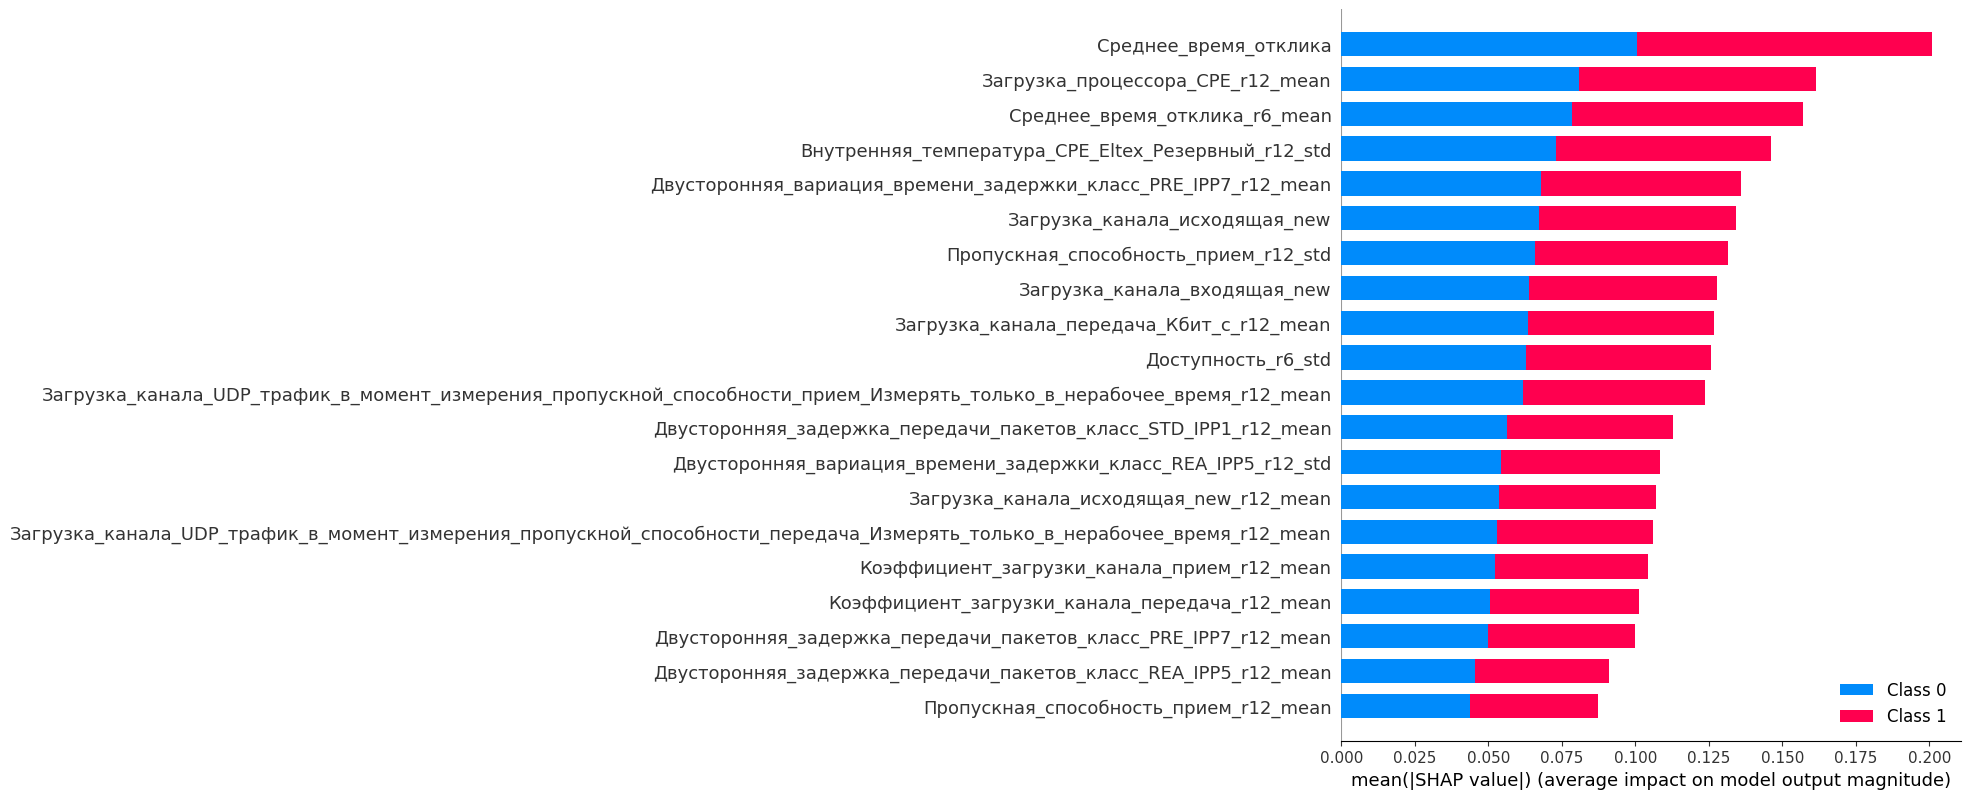

In [ ]:
import shap
explainer = shap.TreeExplainer(lgb_trainer.model_)
shap_values = explainer.shap_values(train_df[FEATURES].iloc[:500])
shap.summary_plot(shap_values, train_df[FEATURES].iloc[:500])

In [ ]:
# booster = lgb_trainer.model_ 
_ = run_full_lgb_explain(
        booster=lgb_trainer.model_,
        df_train=train_df_ts,
        top_n=25,
        sample_size=2000
)

# Prediction

In [3]:
# ------------------------------------------------------------
# 1. imports & constants
# ------------------------------------------------------------
from pathlib import Path
import glob, json
import numpy as np
import pandas as pd
import lightgbm as lgb

BASE_DIR    = Path().resolve()
TEST_DIR    = BASE_DIR / "test"
MODEL_DIR   = BASE_DIR / "models"

DEVICE_COL, TIME_COL, TARGET_COL = "ip_address", "timestamp", "target"

# ------------------------------------------------------------
# 2. helpers
# ------------------------------------------------------------
def load_lgb_model(device_tag: str):
    """
    device_tag  → 'Eltex1_2h' | 'Eltex2_2h' | …
    возвращает (booster, threshold)
    """
    model_path = MODEL_DIR / f"best_lgbm_clf_{device_tag}.txt"
    thr_path   = MODEL_DIR / f"best_lgbm_clf_{device_tag}_thr.txt"

    if not model_path.exists():
        raise FileNotFoundError(f"Model file not found: {model_path}")
    booster = lgb.Booster(model_file=str(model_path))

    thr = 0.5
    if thr_path.exists():
        thr = float(Path(thr_path).read_text().strip())
    return booster, thr


def predict_file(csv_path: Path):
    """
    Читает CSV → делает прогноз → сохраняет *_pred.csv*.
    """
    print(f'***reading file {csv_path}***')
    # --- устройство определяется из имени файла (Eltex1 / Eltex2 / …) ------
    device_family = csv_path.name.split("_")[0]          # 'Eltex1'
    device_tag    = f"{device_family}_2h"                # 'Eltex1_2h'

    booster, thr          = load_lgb_model(device_tag)
    feature_cols          = booster.feature_name()

    # --- данные ------------------------------------------------------------
    df = pd.read_csv(csv_path)
    print(f'file {csv_path} uploaded')
    # гарантируем наличие всех фичей в правильном порядке
    for col in feature_cols:
        if col not in df.columns:
            print(f'отсутствует колонка {col}')
            df[col] = np.nan
    X = df[feature_cols].values.astype("float32")

    # --- прогноз -----------------------------------------------------------
    proba = booster.predict(X, num_iteration=booster.best_iteration)
    pred  = (proba >= thr).astype(int)

    # --- сохранение --------------------------------------------------------
    out = df[[DEVICE_COL, TIME_COL]].copy()
    out["predict"] = pred
    out_path = csv_path.with_name(csv_path.stem + "_pred.csv")
    out.to_csv(out_path, index=False)
    print(f"✓ {csv_path.name}  →  {out_path.name}  (rows={len(out)})")


# ------------------------------------------------------------
# 3. batch inference for *all* test files
# ------------------------------------------------------------
def run_batch(test_dir: Path = TEST_DIR, pattern: str = "*_test_24h_30min.csv"):
    files = sorted(test_dir.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No test files found in {test_dir} with pattern {pattern}")

    for fp in files:
        try:
            predict_file(fp)
        except Exception as e:
            print(f"[ERROR] {fp.name}: {e}")

# ------------------------------------------------------------
# 4. run
# ------------------------------------------------------------
run_batch()

***reading file /home/ii/chd/test/Eltex1_feb_test_24h_30min.csv***
file /home/ii/chd/test/Eltex1_feb_test_24h_30min.csv uploaded
✓ Eltex1_feb_test_24h_30min.csv  →  Eltex1_feb_test_24h_30min_pred.csv  (rows=974032)
***reading file /home/ii/chd/test/Eltex1_mar_test_24h_30min.csv***
file /home/ii/chd/test/Eltex1_mar_test_24h_30min.csv uploaded
✓ Eltex1_mar_test_24h_30min.csv  →  Eltex1_mar_test_24h_30min_pred.csv  (rows=1438030)
***reading file /home/ii/chd/test/Eltex2_feb_test_24h_30min.csv***
file /home/ii/chd/test/Eltex2_feb_test_24h_30min.csv uploaded
✓ Eltex2_feb_test_24h_30min.csv  →  Eltex2_feb_test_24h_30min_pred.csv  (rows=1281607)
***reading file /home/ii/chd/test/Eltex2_mar_test_24h_30min.csv***
file /home/ii/chd/test/Eltex2_mar_test_24h_30min.csv uploaded
✓ Eltex2_mar_test_24h_30min.csv  →  Eltex2_mar_test_24h_30min_pred.csv  (rows=1519389)
